# Data Wrangling Pipeline — Steam Dataset

This section performs a full **data-wrangling and quality-assurance pipeline** on the `all_data.csv` dataset.  
The workflow is designed for **reproducibility**, **clarity**, and **progressive cell execution**, where each numbered step executes one core phase of cleaning or transformation.

---

## Objective
To transform the raw dataset into a clean, analysis-ready format by:
- Standardizing schema and fixing structural inconsistencies  
- Cleaning text, categorical, and numeric data  
- Parsing ownership ranges and pricing logic  
- Recomputing derived metrics (discounts, user scores, playtime hours)  
- Deduplicating by `appid` and enforcing logical consistency  

---

## Workflow Overview
Each step is modular and can be executed independently:

| Step | Operation | Description |
|:----:|:------------------|:-------------|
| 1 | **Load & Inspect** | Read raw CSV safely, preview shape, types, and missingness |
| 2 | **Standardize Schema** | Rename columns, drop noise, enforce naming conventions |
| 3 | **Clean Text Fields** | Strip whitespace, normalize nulls |
| 4 | **Split Multi-Valued Fields** | Expand developer/publisher lists |
| 5 | **Parse Ownership Ranges** | Extract `owners_low`, `owners_high`, and midpoint |
| 6 | **Convert & Validate Numerics** | Ensure proper numeric typing and non-negativity |
| 7 | **Fix Price & Discount Logic** | Convert cents → dollars, recompute discounts |
| 8 | **Repair User Scores** | Recalculate missing or zero scores from vote ratios |
| 9 | **Normalize Playtime** | Convert minutes → hours |
| 10 | **Deduplicate Records** | Keep top-review app per `appid` |
| 11 | **Validate & Outlier Check** | Enforce logical integrity constraints |
| 12 | **Export & Document** | Output clean dataset and schema summary |

---

Each numbered code cell implements one of these operations.


## Step 1: Load & Inspect Data
 ----------------------------
 **Objective**: Load the CSV safely, detect delimiter/encoding automatically, and produce initial metadata inspection.

In [19]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt

# Path to your raw data file
data_path = Path("all_data.csv")  # update path if stored elsewhere

# Robust load function that tests multiple encodings/separators
def robust_read_csv(path):
    seps = [",", ";", "\t", "|"]
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, low_memory=False)
                if df.shape[1] > 1:
                    print(f"Loaded using sep='{sep}' and encoding='{enc}'")
                    return df
            except Exception:
                continue
    df = pd.read_csv(path, engine="python", low_memory=False)
    print("Fallback read used (automatic separator detection).")
    return df

# Load the dataset
df = robust_read_csv(data_path)

# Basic structure
print(f"Shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

# Quick overview of missingness and datatypes
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "missing_pct": (df.isna().sum() / len(df) * 100).round(2)
})
display(summary)

# Display sample
df.head(10)

Loaded using sep=',' and encoding='utf-8'
Shape: (86538, 18)

Column names:
['Unnamed: 0', 'appid', 'name', 'developer', 'publisher', 'score_rank', 'positive', 'negative', 'userscore', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'price', 'initialprice', 'discount', 'ccu']


,dtype,non_null,missing_pct
Unnamed: 0,int64,86538,0.00
appid,int64,86538,0.00
name,object,86520,0.02
developer,object,86227,0.36
publisher,object,85924,0.71
score_rank,float64,47,99.95
positive,int64,86538,0.00
negative,int64,86538,0.00
userscore,int64,86538,0.00
owners,object,86538,0.00


,Unnamed: 0,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
0,0,10,Counter-Strike,Valve,Valve,NaN,243818,6427,0,"10,000,000 .. 20,000,000",12222,563,204,88,199.0,999.0,80.0,7323
1,1,20,Team Fortress Classic,Valve,Valve,NaN,7602,1136,0,"1,000,000 .. 2,000,000",361,6722,15,6722,499.0,499.0,0.0,66
2,2,30,Day of Defeat,Valve,Valve,NaN,6414,688,0,"5,000,000 .. 10,000,000",859,3485,23,3604,499.0,499.0,0.0,87
3,3,40,Deathmatch Classic,Valve,Valve,NaN,2618,545,0,"5,000,000 .. 10,000,000",353,4,10,4,499.0,499.0,0.0,7
4,4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,24363,1198,0,"2,000,000 .. 5,000,000",528,78,162,78,499.0,499.0,0.0,74
5,5,60,Ricochet,Valve,Valve,NaN,4989,1039,0,"200,000 .. 500,000",233,0,4,0,124.0,499.0,75.0,4
6,6,70,Half-Life,Valve,Valve,NaN,143086,5135,0,"10,000,000 .. 20,000,000",635,481,136,39,999.0,999.0,0.0,634
7,7,80,Counter-Strike: Condition Zero,Valve,Valve,NaN,24271,2287,0,"5,000,000 .. 10,000,000",1070,13,32,13,999.0,999.0,0.0,276
8,8,100,Counter-Strike: Condition Zero,Valve,Valve,NaN,13442,1535,0,"10,000,000 .. 20,000,000",181,16,28,16,999.0,999.0,0.0,83
9,9,130,Half-Life: Blue Shift,Gearbox Software,Valve,NaN,17384,1410,0,"1,000,000 .. 2,000,000",337,1,97,1,499.0,499.0,0.0,35


## Step 2: Standardize Schema
--------------------------
**Objective**: Drop unnecessary columns, normalize headers, and prepare a clean schema
for downstream transformations.

In [ ]:
# Drop auto-generated index columns if present
index_like_cols = [c for c in df.columns if re.match(r"Unnamed: 0", c, re.IGNORECASE)]
if index_like_cols:
    print(f"Dropping columns: {index_like_cols}")
    df = df.drop(columns=index_like_cols)

# Standardize column names: lower-case, snake_case, alphanumeric only
df.columns = (
    df.columns.str.strip()                # remove leading/trailing whitespace
             .str.replace(r"\s+", "_", regex=True)  # replace spaces with underscores
             .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)  # remove invalid chars
             .str.lower()                 # enforce lowercase
)

# Confirm transformation
print("Schema standardized.")
print(f"Columns after standardization ({len(df.columns)}):\n{df.columns.tolist()}")

# Preview shape and types
print("\nShape:", df.shape)
df.info()

Dropping columns: ['Unnamed: 0']
Schema standardized.
Columns after standardization (17):
['appid', 'name', 'developer', 'publisher', 'score_rank', 'positive', 'negative', 'userscore', 'owners', 'average_forever', 'average_2weeks', 'median_forever', 'median_2weeks', 'price', 'initialprice', 'discount', 'ccu']

Shape: (86538, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86538 entries, 0 to 86537
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            86538 non-null  int64  
 1   name             86520 non-null  object 
 2   developer        86227 non-null  object 
 3   publisher        85924 non-null  object 
 4   score_rank       47 non-null     float64
 5   positive         86538 non-null  int64  
 6   negative         86538 non-null  int64  
 7   userscore        86538 non-null  int64  
 8   owners           86538 non-null  object 
 9   average_forever  86538 non-null  int64  
 10  ave

## Step 3: Clean Text Fields
--------------------------
**Objective:** Standardize textual fields, trim whitespace, and replace blanks  
or placeholder `"nan"` values with proper `NaN`.

In [7]:
text_cols = [c for c in df.columns if df[c].dtype == "object"]

for c in text_cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    )

missing_summary = (
    df[text_cols].isna().mean().sort_values(ascending=False).round(3) * 100
)
print(missing_summary)

df[text_cols].head(10)

publisher            0.7
publisher_raw        0.7
publisher_primary    0.7
developer            0.4
developer_raw        0.4
developer_primary    0.4
name                 0.0
owners               0.0
dtype: float64


,name,developer,publisher,owners,developer_raw,developer_primary,publisher_raw,publisher_primary
0,Counter-Strike,Valve,Valve,"10,000,000 .. 20,000,000",Valve,Valve,Valve,Valve
1,Team Fortress Classic,Valve,Valve,"1,000,000 .. 2,000,000",Valve,Valve,Valve,Valve
2,Day of Defeat,Valve,Valve,"5,000,000 .. 10,000,000",Valve,Valve,Valve,Valve
3,Deathmatch Classic,Valve,Valve,"5,000,000 .. 10,000,000",Valve,Valve,Valve,Valve
4,Half-Life: Opposing Force,Gearbox Software,Valve,"2,000,000 .. 5,000,000",Gearbox Software,Gearbox Software,Valve,Valve
5,Ricochet,Valve,Valve,"200,000 .. 500,000",Valve,Valve,Valve,Valve
6,Half-Life,Valve,Valve,"10,000,000 .. 20,000,000",Valve,Valve,Valve,Valve
7,Counter-Strike: Condition Zero,Valve,Valve,"5,000,000 .. 10,000,000",Valve,Valve,Valve,Valve
8,Counter-Strike: Condition Zero,Valve,Valve,"10,000,000 .. 20,000,000",Valve,Valve,Valve,Valve
9,Half-Life: Blue Shift,Gearbox Software,Valve,"1,000,000 .. 2,000,000",Gearbox Software,Gearbox Software,Valve,Valve


## Step 4: Split Multi-Valued Fields
--------------------------
**Objective:** Expand comma-separated entries in the `developer` and `publisher` columns into structured lists,  
extract the **primary entity**, and record the **number of entities** per record.  
Finally, rejoin these lists with a pipe (`|`) for clean CSV compatibility.

In [8]:
for c in ["developer", "publisher"]:
    if c in df.columns:
        df[f"{c}_raw"] = df[c]
        df[c] = (
            df[c]
            .astype(str)
            .str.split(",")
            .apply(lambda lst: [x.strip() for x in lst if x.strip()] if isinstance(lst, list) else np.nan)
        )
        df[f"{c}_primary"] = df[c].apply(lambda lst: lst[0] if isinstance(lst, list) and len(lst) > 0 else np.nan)
        df[f"{c}_count"] = df[c].apply(lambda lst: len(lst) if isinstance(lst, list) else 0)

for c in ["developer", "publisher"]:
    if c in df.columns:
        df[c] = df[c].apply(lambda lst: "|".join(lst) if isinstance(lst, list) else lst)

df.head(10)[["developer", "publisher", "developer_primary", "publisher_primary", "developer_count", "publisher_count"]]


,developer,publisher,developer_primary,publisher_primary,developer_count,publisher_count
0,Valve,Valve,Valve,Valve,1,1
1,Valve,Valve,Valve,Valve,1,1
2,Valve,Valve,Valve,Valve,1,1
3,Valve,Valve,Valve,Valve,1,1
4,Gearbox Software,Valve,Gearbox Software,Valve,1,1
5,Valve,Valve,Valve,Valve,1,1
6,Valve,Valve,Valve,Valve,1,1
7,Valve,Valve,Valve,Valve,1,1
8,Valve,Valve,Valve,Valve,1,1
9,Gearbox Software,Valve,Gearbox Software,Valve,1,1


## Step 5: Parse Ownership Ranges
--------------------------
**Objective:** Convert the textual ownership ranges in the `owners` column  
(e.g., `"20,000 .. 50,000"`) into three numeric fields:
- `owners_low` → lower bound  
- `owners_high` → upper bound  
- `owners_mid` → midpoint estimate  
This enables quantitative analysis of ownership data and facilitates grouping, regression, or visualization.

In [6]:
if "owners" in df.columns:
    s = df["owners"].astype(str).str.replace(",", "", regex=False)
    m = s.str.extract(r"^\s*(\d+)\s*\.\.\s*(\d+)\s*$")
    df["owners_low"] = pd.to_numeric(m[0], errors="coerce")
    df["owners_high"] = pd.to_numeric(m[1], errors="coerce")
    df["owners_mid"] = ((df["owners_low"] + df["owners_high"]) / 2).round().astype("Int64")
    display(df[["owners", "owners_low", "owners_high", "owners_mid"]].head(10))


,owners,owners_low,owners_high,owners_mid
0,"10,000,000 .. 20,000,000",10000000,20000000,15000000
1,"1,000,000 .. 2,000,000",1000000,2000000,1500000
2,"5,000,000 .. 10,000,000",5000000,10000000,7500000
3,"5,000,000 .. 10,000,000",5000000,10000000,7500000
4,"2,000,000 .. 5,000,000",2000000,5000000,3500000
5,"200,000 .. 500,000",200000,500000,350000
6,"10,000,000 .. 20,000,000",10000000,20000000,15000000
7,"5,000,000 .. 10,000,000",5000000,10000000,7500000
8,"10,000,000 .. 20,000,000",10000000,20000000,15000000
9,"1,000,000 .. 2,000,000",1000000,2000000,1500000


## Step 6: Convert and Validate Numeric Fields
--------------------------
**Objective:** Convert relevant columns to numeric datatypes, coerce invalid entries to `NaN`,  
and ensure all numeric values are **non-negative**. This step eliminates formatting inconsistencies  
(such as numbers stored as strings or with non-numeric symbols) and prepares clean quantitative fields  
for further transformation and analysis.

In [9]:
cols_numeric = [
    "positive", "negative", "ccu",
    "average_forever", "average_2weeks",
    "median_forever", "median_2weeks"
]

for c in cols_numeric:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].replace([np.inf, -np.inf], np.nan)
        df[c] = df[c].where(df[c] >= 0)

summary_6 = []
for c in cols_numeric:
    if c in df.columns:
        s = df[c]
        summary_6.append({
            "column": c,
            "non_null": int(s.notna().sum()),
            "missing_pct": float(s.isna().mean() * 100),
            "min": float(s.min(skipna=True)) if s.notna().any() else np.nan,
            "max": float(s.max(skipna=True)) if s.notna().any() else np.nan
        })
pd.DataFrame(summary_6)

,column,non_null,missing_pct,min,max
0,positive,86538,0.0,0.0,7642084.0
1,negative,86538,0.0,0.0,1173003.0
2,ccu,86538,0.0,0.0,1013936.0
3,average_forever,86538,0.0,0.0,608013.0
4,average_2weeks,86538,0.0,0.0,19953.0
5,median_forever,86538,0.0,0.0,608015.0
6,median_2weeks,86538,0.0,0.0,19953.0


## Step 7: Fix Price & Discount Logic
--------------------------
**Objective:** Normalize pricing by converting values stored in cents to dollars and enforce logical
relationships between `price`, `initialprice`, and `discount`. Recompute `discount = 100 × (1 − price / initialprice)`
when applicable, clip to [0, 100], and set invalid or negative prices to `NaN`.

In [10]:
for c in ["price", "initialprice"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        if (df[c] > 1000).mean() > 0.01 or df[c].max(skipna=True) > 999:
            df[c] = (df[c] / 100.0).round(2)
        df[c] = df[c].where(df[c] >= 0)

if {"discount", "price", "initialprice"}.issubset(df.columns):
    df["discount"] = pd.to_numeric(df["discount"], errors="coerce")
    recomputed = pd.Series(
        np.where(df["initialprice"] > 0, (1 - (df["price"] / df["initialprice"])) * 100, np.nan),
        index=df.index
    )
    mask = df["discount"].isna() | (np.abs(df["discount"] - recomputed) > 1.0)
    df.loc[mask, "discount"] = recomputed.loc[mask]
    df["discount"] = df["discount"].clip(0, 100).round(2)

df[["price", "initialprice", "discount"]].head(10)


,price,initialprice,discount
0,1.99,9.99,80.0
1,4.99,4.99,0.0
2,4.99,4.99,0.0
3,4.99,4.99,0.0
4,4.99,4.99,0.0
5,1.24,4.99,75.0
6,9.99,9.99,0.0
7,9.99,9.99,0.0
8,9.99,9.99,0.0
9,4.99,4.99,0.0


## Step 8: Repair User Scores
--------------------------
**Objective:** Recalculate or fill missing `userscore` values based on player feedback data.  
If the dataset contains `positive` and `negative` review counts, derive  
`userscore = 100 × (positive / (positive + negative))` when votes exist.  
Ensure all scores are within [0, 100] and replace zeros or missing values with recomputed estimates.  
This restores valid user-rating metrics for reliable analytical use.

In [13]:
if {"userscore", "positive", "negative"}.issubset(df.columns):
    df["userscore"] = pd.to_numeric(df["userscore"], errors="coerce")
    pos = pd.to_numeric(df["positive"], errors="coerce").fillna(0)
    neg = pd.to_numeric(df["negative"], errors="coerce").fillna(0)
    total = pos + neg

    inferred = np.where(total > 0, (pos / total) * 100.0, np.nan)

    needs = df["userscore"].isna() | (df["userscore"] == 0)
    has_votes = total > 0
    df.loc[needs & has_votes, "userscore"] = inferred[needs & has_votes]
    df.loc[~has_votes, "userscore"] = np.where(needs[~has_votes], np.nan, df.loc[~has_votes, "userscore"])

    df["userscore"] = df["userscore"].clip(0, 100).round(2)

df[["positive", "negative", "userscore"]].head(10)

,positive,negative,userscore
0,243818,6427,97.43
1,7602,1136,87.00
2,6414,688,90.31
3,2618,545,82.77
4,24363,1198,95.31
5,4989,1039,82.76
6,143086,5135,96.54
7,24271,2287,91.39
8,13442,1535,89.75
9,17384,1410,92.50


## Step 9: Normalize Playtime
--------------------------
**Objective:** Convert playtime metrics from minutes to hours for readability and analysis.
Creates companion fields: `average_forever_hours`, `average_2weeks_hours`,
`median_forever_hours`, and `median_2weeks_hours` while preserving original minute values.

In [14]:
time_cols = ["average_forever", "average_2weeks", "median_forever", "median_2weeks"]

for c in time_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[f"{c}_hours"] = (df[c] / 60.0).round(2)

df[[col for col in df.columns if col.endswith("_hours")]].head(10)

,average_forever_hours,average_2weeks_hours,median_forever_hours,median_2weeks_hours
0,203.70,9.38,3.40,1.47
1,6.02,112.03,0.25,112.03
2,14.32,58.08,0.38,60.07
3,5.88,0.07,0.17,0.07
4,8.80,1.30,2.70,1.30
5,3.88,0.00,0.07,0.00
6,10.58,8.02,2.27,0.65
7,17.83,0.22,0.53,0.22
8,3.02,0.27,0.47,0.27
9,5.62,0.02,1.62,0.02


## Step 10: Deduplicate Records
--------------------------
**Objective:** Remove duplicate application entries by `appid`.  
Retain the row with the highest `reviews_total` (`positive + negative`); use the highest `initialprice` as a tie-breaker.  
Report how many rows were removed and the remaining count after deduplication.

In [15]:
if "appid" in df.columns:
    df["appid"] = pd.to_numeric(df["appid"], errors="coerce").astype("Int64")
    before_n = len(df)
    if {"positive", "negative"}.issubset(df.columns):
        df["reviews_total"] = pd.to_numeric(df["positive"], errors="coerce").fillna(0) + pd.to_numeric(df["negative"], errors="coerce").fillna(0)
    else:
        df["reviews_total"] = 0
    if "initialprice" in df.columns:
        df["initialprice"] = pd.to_numeric(df["initialprice"], errors="coerce")
    df = df.sort_values(["appid", "reviews_total", "initialprice"], ascending=[True, False, False])
    df = df.drop_duplicates(subset=["appid"], keep="first")
    after_n = len(df)
    print(f"Deduplicated on appid. Removed {before_n - after_n} rows. Remaining: {after_n}")
else:
    print("No 'appid' column found; skipping deduplication.")

Deduplicated on appid. Removed 4038 rows. Remaining: 82500


## Step 11: Validate Integrity & Outliers
--------------------------
**Objective:** Enforce logical data rules and surface anomalous values for review.  
Checks include:
- `price` and `initialprice` nonnegative and `price <= initialprice`
- `discount` and `userscore` within [0, 100]
- `owners_low <= owners_high`
- Counts and playtime fields nonnegative
Also flag statistical outliers using the IQR method for key numeric columns.

In [17]:
violations = []

def add_violation(mask, col, rule):
    if mask.any():
        ids = df.index[mask]
        violations.append(pd.DataFrame({
            "index": ids,
            "column": col,
            "rule": rule
        }))

# Integrity checks
if {"price", "initialprice"}.issubset(df.columns):
    p = pd.to_numeric(df["price"], errors="coerce")
    ip = pd.to_numeric(df["initialprice"], errors="coerce")
    add_violation(p < 0, "price", "price >= 0")
    add_violation(ip < 0, "initialprice", "initialprice >= 0")
    mask_pi = (p.notna() & ip.notna()) & (p > ip)
    add_violation(mask_pi, "price,initialprice", "price <= initialprice")

if "discount" in df.columns:
    d = pd.to_numeric(df["discount"], errors="coerce")
    add_violation((d < 0) | (d > 100), "discount", "0 <= discount <= 100")

if "userscore" in df.columns:
    us = pd.to_numeric(df["userscore"], errors="coerce")
    add_violation((us < 0) | (us > 100), "userscore", "0 <= userscore <= 100")

if {"owners_low", "owners_high"}.issubset(df.columns):
    ol = pd.to_numeric(df["owners_low"], errors="coerce")
    oh = pd.to_numeric(df["owners_high"], errors="coerce")
    add_violation((ol.notna() & oh.notna()) & (ol > oh), "owners_low,owners_high", "owners_low <= owners_high")

for c in ["positive", "negative", "ccu", "average_forever", "average_2weeks", "median_forever", "median_2weeks"]:
    if c in df.columns:
        v = pd.to_numeric(df[c], errors="coerce")
        add_violation(v < 0, c, f"{c} >= 0")

violations_df = pd.concat(violations, ignore_index=True) if violations else pd.DataFrame(columns=["index", "column", "rule"])
print(f"Integrity violations: {len(violations_df)} rows")
display(violations_df.head(20))

# Outlier detection (IQR method)
outlier_rows = []
iqr_cols = [c for c in ["price", "initialprice", "positive", "negative", "ccu",
                        "average_forever", "average_2weeks", "median_forever", "median_2weeks",
                        "average_forever_hours", "average_2weeks_hours", "median_forever_hours", "median_2weeks_hours"]
            if c in df.columns]

for c in iqr_cols:
    s = pd.to_numeric(df[c], errors="coerce").dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (pd.to_numeric(df[c], errors="coerce") < lower) | (pd.to_numeric(df[c], errors="coerce") > upper)
    idx = df.index[mask.fillna(False)]
    if len(idx):
        outlier_rows.append(pd.DataFrame({
            "index": idx,
            "column": c,
            "q1": q1,
            "q3": q3,
            "lower": lower,
            "upper": upper,
            "value": df.loc[idx, c].values
        }))

outliers_df = pd.concat(outlier_rows, ignore_index=True) if outlier_rows else pd.DataFrame(columns=["index","column","q1","q3","lower","upper","value"])
print(f"Outliers flagged: {len(outliers_df)} rows across {len(iqr_cols)} columns")
display(outliers_df.head(20))

Integrity violations: 0 rows


,index,column,rule


Outliers flagged: 130091 rows across 13 columns


,index,column,q1,q3,lower,upper,value
0,87,price,160.0,999.0,-1098.5,2257.5,2999.0
1,147,price,160.0,999.0,-1098.5,2257.5,3999.0
2,148,price,160.0,999.0,-1098.5,2257.5,3999.0
3,157,price,160.0,999.0,-1098.5,2257.5,3699.0
4,160,price,160.0,999.0,-1098.5,2257.5,2499.0
5,164,price,160.0,999.0,-1098.5,2257.5,2499.0
6,211,price,160.0,999.0,-1098.5,2257.5,2999.0
7,267,price,160.0,999.0,-1098.5,2257.5,2999.0
8,273,price,160.0,999.0,-1098.5,2257.5,2999.0
9,317,price,160.0,999.0,-1098.5,2257.5,2499.0


## Step 12: Export & Document Outputs
--------------------------
**Objective:** Save the fully cleaned dataset and its metadata artifacts for reproducibility and downstream use.  
Exports include:
- **Clean CSV:** Final dataset in human-readable format  
- **Parquet file:** Columnar version optimized for analytical workloads  
- **Schema summary:** Data types, non-null counts, and uniqueness metrics  
- **Numeric profile:** Descriptive statistics for quantitative columns  

All artifacts are written to the `artifacts/` directory to maintain a clear and organized output structure.

In [18]:
outdir = Path("artifacts")
outdir.mkdir(parents=True, exist_ok=True)

clean_csv_path = outdir / "all_data_cleaned.csv"
schema_csv_path = outdir / "cleaned_schema_summary.csv"
profile_csv_path = outdir / "cleaned_basic_profile.csv"
clean_parquet_path = outdir / "all_data_cleaned.parquet"

df.to_csv(clean_csv_path, index=False)

parquet_saved = False
try:
    df.to_parquet(clean_parquet_path, index=False)
    parquet_saved = True
except Exception:
    parquet_saved = False

schema_df = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "non_null": [int(df[c].notna().sum()) for c in df.columns],
    "missing_pct": [(df[c].isna().mean() * 100).round(2) for c in df.columns],
    "n_unique": [int(df[c].nunique(dropna=True)) for c in df.columns],
})
schema_df.to_csv(schema_csv_path, index=False)

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
profile_df = df[num_cols].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T.reset_index().rename(columns={"index":"column"})
profile_df.to_csv(profile_csv_path, index=False)

print(f"Clean CSV: {clean_csv_path}")
print(f"Clean Parquet: {clean_parquet_path} (saved={parquet_saved})")
print(f"Schema summary: {schema_csv_path}")
print(f"Basic numeric profile: {profile_csv_path}")

Clean CSV: artifacts\all_data_cleaned.csv
Clean Parquet: artifacts\all_data_cleaned.parquet (saved=True)
Schema summary: artifacts\cleaned_schema_summary.csv
Basic numeric profile: artifacts\cleaned_basic_profile.csv


In [25]:
# PRELUDE: Load cleaned dataset and set up environment
import warnings, pandas as pd, numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)

# Adjust the path to where you saved Step 12 outputs
CLEAN_CSV_CANDIDATES = [
    "artifacts/all_data_cleaned.csv",
    "/mnt/data/all_data_cleaned.csv",  # fallback if you ran my earlier script
    "all_data_cleaned.csv"
]

df = None
for p in CLEAN_CSV_CANDIDATES:
    try:
        df = pd.read_csv(p, low_memory=False)
        print(f"Loaded cleaned dataset from: {p}")
        break
    except Exception:
        pass

if df is None:
    raise FileNotFoundError("Could not locate the cleaned dataset. Verify the path to all_data_cleaned.csv.")

# Minimal sanity: reconstruct key columns if missing
if "owners_mid" not in df.columns:
    if {"owners_low","owners_high"}.issubset(df.columns):
        ol = pd.to_numeric(df["owners_low"], errors="coerce")
        oh = pd.to_numeric(df["owners_high"], errors="coerce")
        df["owners_mid"] = ((ol + oh) / 2).round().astype("Int64")
    elif "owners" in df.columns:
        s = df["owners"].astype(str).str.replace(",", "", regex=False)
        m = s.str.extract(r"^\s*(\d+)\s*\.\.\s*(\d+)\s*$")
        df["owners_low"]  = pd.to_numeric(m[0], errors="coerce")
        df["owners_high"] = pd.to_numeric(m[1], errors="coerce")
        df["owners_mid"]  = ((df["owners_low"] + df["owners_high"]) / 2).round().astype("Int64")

# Ensure hour features exist if you plan to use them in EDA/FE
for c in ["average_forever","average_2weeks","median_forever","median_2weeks"]:
    if c in df.columns and f"{c}_hours" not in df.columns:
        df[f"{c}_hours"] = (pd.to_numeric(df[c], errors="coerce") / 60.0).round(2)

print("df ready for Step 13+")
print(df.shape, "columns:", len(df.columns))

Loaded cleaned dataset from: artifacts/all_data_cleaned.csv
df ready for Step 13+
(82500, 26) columns: 26


## Step 13: Exploratory Data Analysis (EDA)
--------------------------
**Objective:** Perform an initial exploration of the cleaned dataset to understand its structure, patterns, and potential relationships between key variables.

**Key Actions:**
- Compute and visualize summary statistics for core numerical features (`owners_mid`, `price`, `discount`, `userscore`, `positive`, `negative`, `ccu`, and playtime metrics).  
- Create derived indicators such as:
  - `sentiment = positive / (positive + negative)`  
  - `engagement_rate_2w = average_2weeks_hours / owners_mid`  
  - `price_per_hour = price / average_forever_hours`
- Apply log-transformations to reduce skew in heavy-tailed variables.  
- Generate correlation heatmaps to assess multicollinearity among numeric variables.  
- Conduct bivariate visualizations (e.g., `price vs owners_mid`, `userscore vs sentiment`).  
- Define a binary target variable `success_top10` to mark games in the top decile of ownership.  

**Expected Outcome:**  
Clear insight into feature distributions, feature–target relationships, and the preliminary discovery of variables most correlated with success or engagement. This sets the analytical foundation for subsequent feature engineering and modeling.

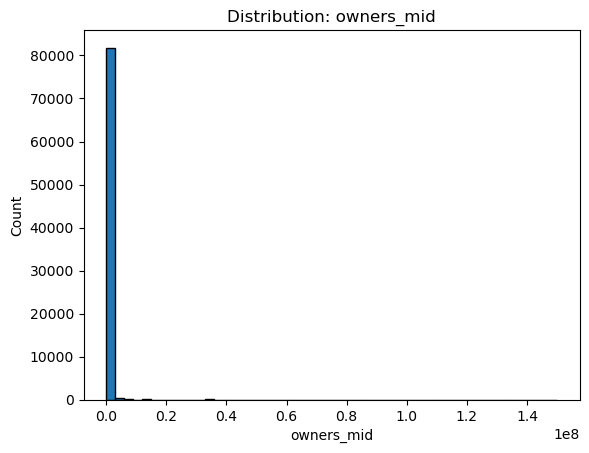

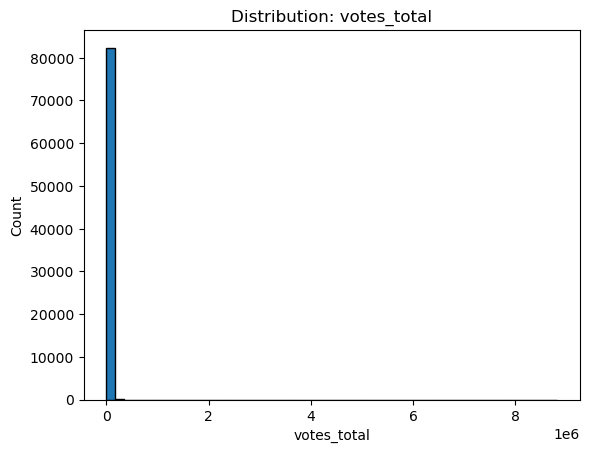

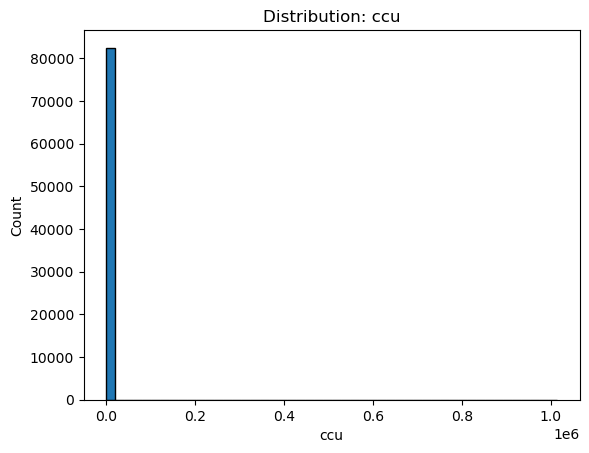

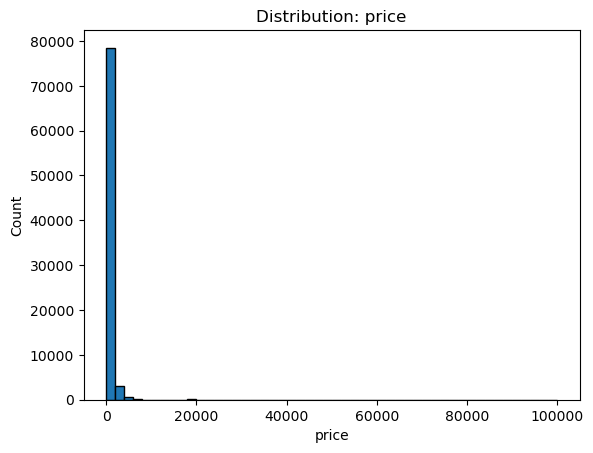

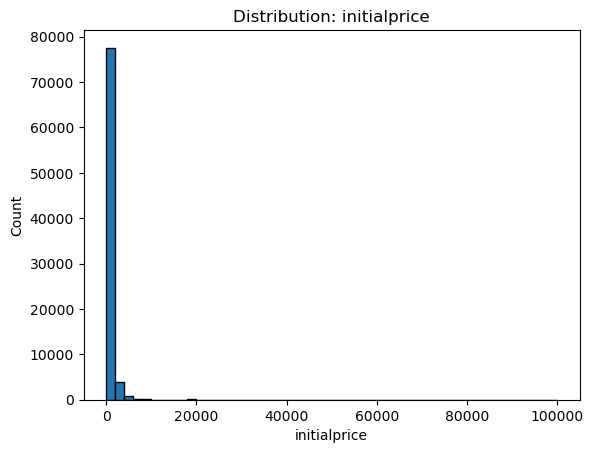

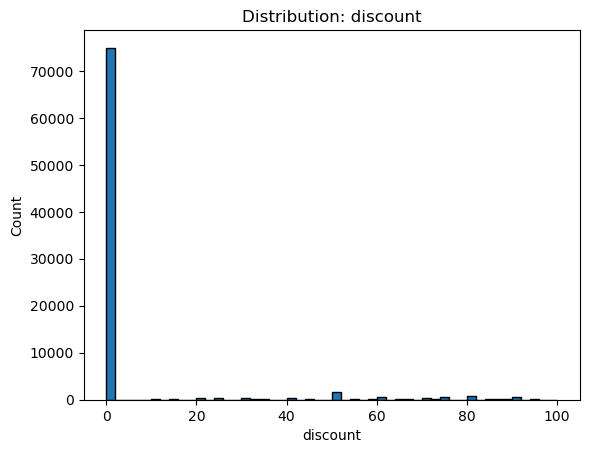

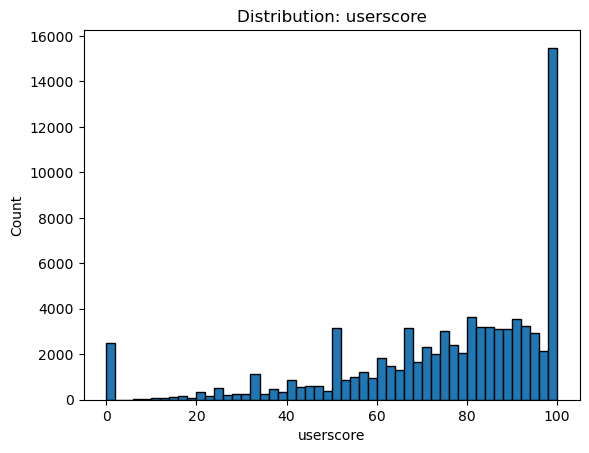

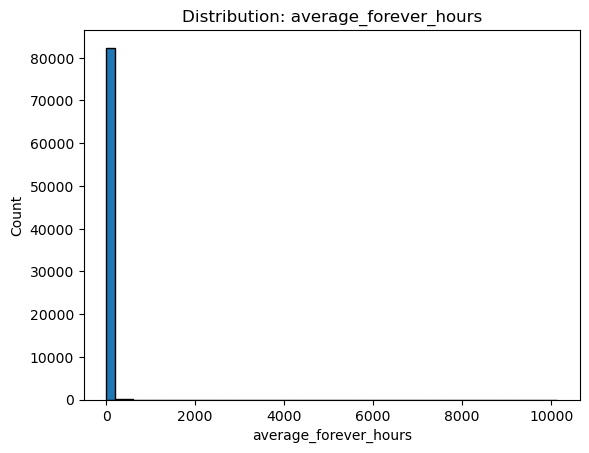

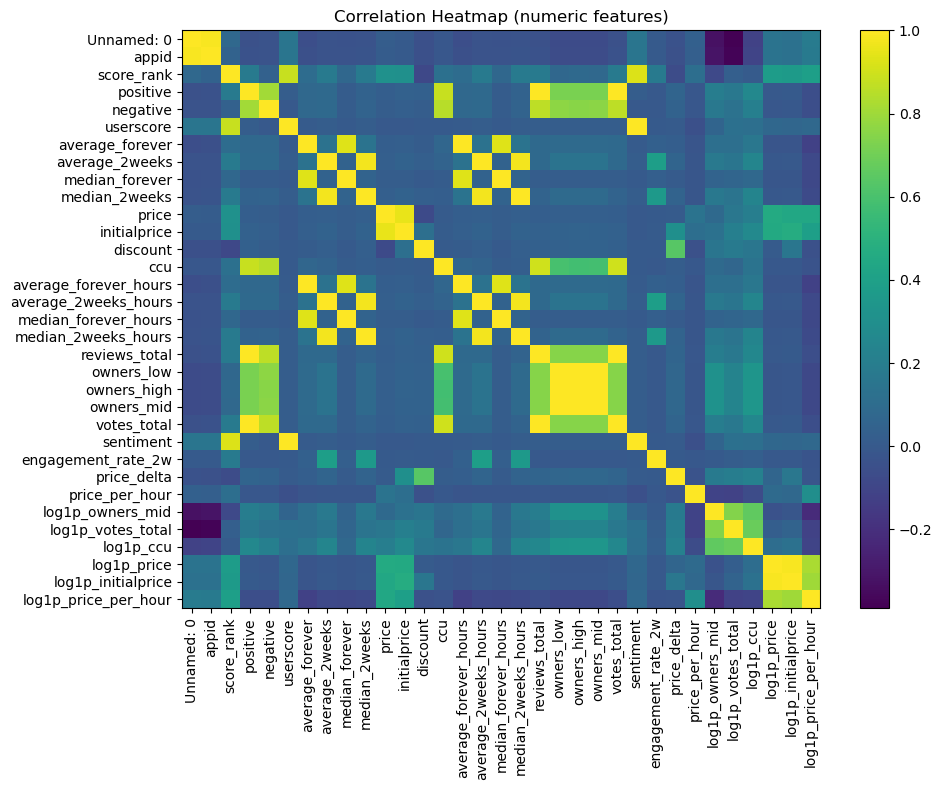

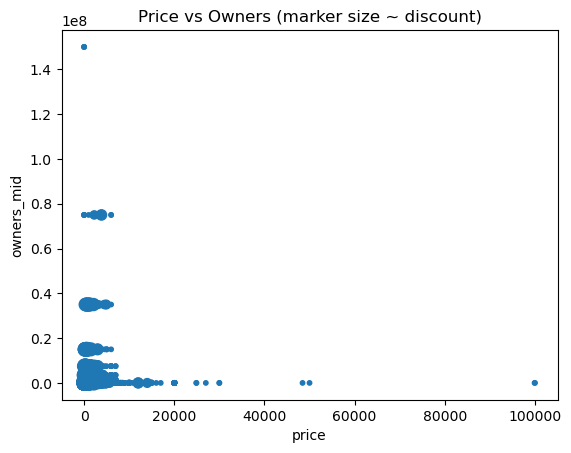

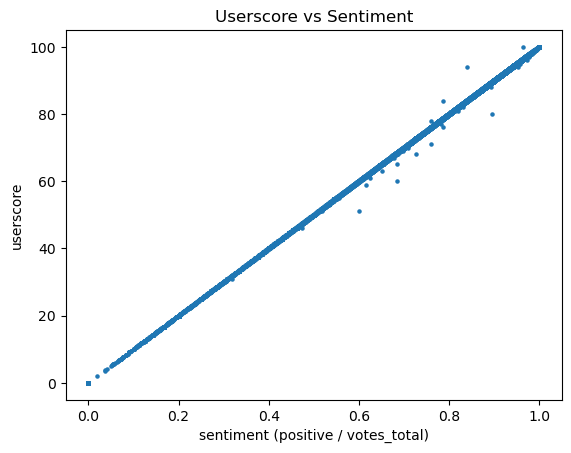

Top-decile owners_mid threshold: 150000.0


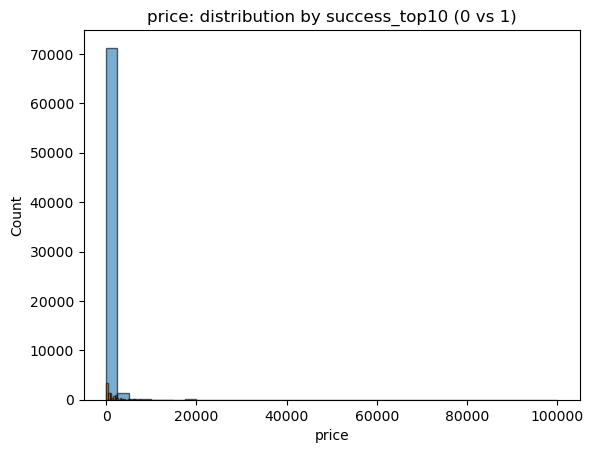

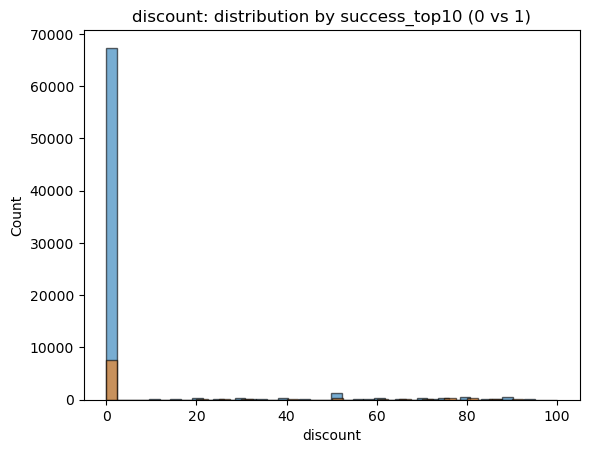

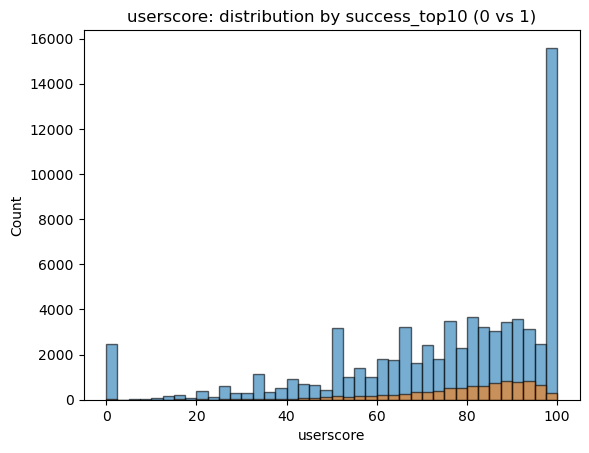

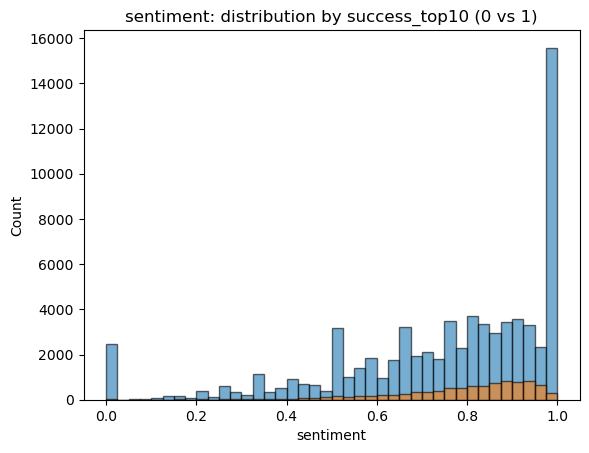

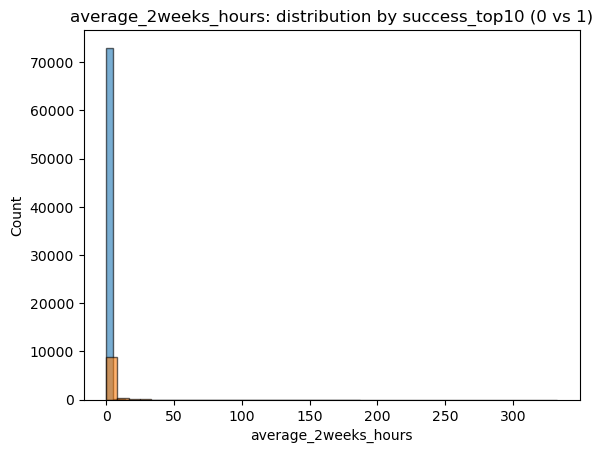

,count,mean,std,min,1%,5%,50%,95%,99%,max
owners_mid,82500.0,129004.0,1492129.845923,10000.0,10000.0,10000.0,10000.0,350000.0,1500000.0,150000000.0
votes_total,82500.0,1790.718885,38742.086921,0.0,1.0,1.0,24.0,2825.05,26043.09,8815087.0
sentiment,81948.0,0.753788,0.238814,0.0,0.0,0.26087,0.8125,1.0,1.0,1.0
ccu,82500.0,69.723079,3934.094053,0.0,0.0,0.0,0.0,21.0,443.0,1013936.0
price,82472.0,757.543469,1292.071305,0.0,0.0,0.0,499.0,1999.0,4499.0,99998.0
initialprice,82479.0,830.296172,1356.453244,0.0,0.0,0.0,499.0,2499.0,4999.0,99998.0
discount,82479.0,5.333891,18.004371,0.0,0.0,0.0,0.0,51.0,85.0,100.0
userscore,81948.0,75.37828,23.8817,0.0,0.0,26.09,81.25,100.0,100.0,100.0
average_forever_hours,82500.0,3.983874,51.408764,0.0,0.0,0.0,0.0,14.6705,52.5505,10133.55
engagement_rate_2w,82500.0,0.000002,0.000103,0.0,0.0,0.0,0.0,0.0,0.000013,0.018718


In [26]:
# ---- Derived features (safe guards included) ----
df["votes_total"] = pd.to_numeric(df.get("positive"), errors="coerce").fillna(0) + pd.to_numeric(df.get("negative"), errors="coerce").fillna(0)
df["sentiment"] = np.where(df["votes_total"] > 0, df["positive"] / df["votes_total"], np.nan)
df["engagement_rate_2w"] = np.where(
    pd.to_numeric(df.get("owners_mid"), errors="coerce") > 0,
    pd.to_numeric(df.get("average_2weeks_hours"), errors="coerce") / pd.to_numeric(df.get("owners_mid"), errors="coerce"),
    np.nan
)
df["price_delta"] = pd.to_numeric(df.get("initialprice"), errors="coerce") - pd.to_numeric(df.get("price"), errors="coerce")
df["price_per_hour"] = np.where(
    pd.to_numeric(df.get("average_forever_hours"), errors="coerce") > 0,
    pd.to_numeric(df.get("price"), errors="coerce") / pd.to_numeric(df.get("average_forever_hours"), errors="coerce"),
    np.nan
)

# Log transforms for heavy-tailed variables
for c in ["owners_mid", "votes_total", "ccu", "price", "initialprice", "price_per_hour"]:
    if c in df.columns:
        df[f"log1p_{c}"] = np.log1p(pd.to_numeric(df[c], errors="coerce"))

# ---- Univariate distributions ----
uni_cols = [c for c in ["owners_mid", "votes_total", "ccu", "price", "initialprice", "discount", "userscore", "average_forever_hours"] if c in df.columns]
for c in uni_cols:
    s = pd.to_numeric(df[c], errors="coerce")
    plt.figure()
    s.plot(kind="hist", bins=50, edgecolor="black")
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

# ---- Correlation heatmap on numeric subset ----
num_df = df.select_dtypes(include=[np.number]).copy()
num_df = num_df.replace([np.inf, -np.inf], np.nan)
corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation="nearest", aspect="auto")
plt.title("Correlation Heatmap (numeric features)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

# ---- Bivariate probes ----
# Scatter: price vs owners_mid with discount as marker size proxy
if {"price", "owners_mid"}.issubset(df.columns):
    x = pd.to_numeric(df["price"], errors="coerce")
    y = pd.to_numeric(df["owners_mid"], errors="coerce")
    size = pd.to_numeric(df.get("discount"), errors="coerce").fillna(0) + 10
    plt.figure()
    plt.scatter(x, y, s=size)
    plt.xlabel("price")
    plt.ylabel("owners_mid")
    plt.title("Price vs Owners (marker size ~ discount)")
    plt.show()

# userscore vs sentiment sanity check
if {"userscore", "sentiment"}.issubset(df.columns):
    xs = pd.to_numeric(df["sentiment"], errors="coerce")
    ys = pd.to_numeric(df["userscore"], errors="coerce")
    plt.figure()
    plt.scatter(xs, ys, s=5)
    plt.xlabel("sentiment (positive / votes_total)")
    plt.ylabel("userscore")
    plt.title("Userscore vs Sentiment")
    plt.show()

# ---- Success label probe (top decile owners) ----
if "owners_mid" in df.columns:
    threshold = pd.to_numeric(df["owners_mid"], errors="coerce").quantile(0.90)
    df["success_top10"] = (pd.to_numeric(df["owners_mid"], errors="coerce") >= threshold).astype("Int64")
    print(f"Top-decile owners_mid threshold: {threshold}")
    # Compare distributions across success label for a few features
    probe_cols = [c for c in ["price", "discount", "userscore", "sentiment", "average_2weeks_hours"] if c in df.columns]
    for c in probe_cols:
        s0 = pd.to_numeric(df.loc[df["success_top10"] == 0, c], errors="coerce")
        s1 = pd.to_numeric(df.loc[df["success_top10"] == 1, c], errors="coerce")
        plt.figure()
        s0.plot(kind="hist", bins=40, alpha=0.6, edgecolor="black")
        s1.plot(kind="hist", bins=40, alpha=0.6, edgecolor="black")
        plt.title(f"{c}: distribution by success_top10 (0 vs 1)")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.show()

# ---- EDA summary table (key stats) ----
eda_cols = [c for c in [
    "owners_mid","votes_total","sentiment","ccu","price","initialprice","discount",
    "userscore","average_forever_hours","engagement_rate_2w","price_delta","price_per_hour"
] if c in df.columns]

eda_summary = df[eda_cols].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T
display(eda_summary.round(3))

## Step 14: Feature Engineering
--------------------------
**Objective:** Create targets and transform raw variables into modeling-ready features while preventing leakage.

**Key Actions:**
- **Targets**
  - `y_reg_log_owners = log1p(owners_mid)` for regression.
  - `y_clf_success_top10 = 1{ owners_mid ≥ 90th percentile }` for classification.
- **Derived Metrics**
  - `votes_total = positive + negative`
  - `sentiment = positive / votes_total` (when `votes_total > 0`)
  - `engagement_rate_2w = average_2weeks_hours / owners_mid`
  - `price_delta = initialprice − price`
  - `price_per_hour = price / average_forever_hours`
- **Categorical Signals**
  - Frequency-encode `developer_primary` and `publisher_primary`; retain `*_count`.
- **Transforms**
  - Impute missing numerics (median) and scale features (standardization).
- **Design Matrices**
  - Assemble `X_reg`, `y_reg_log_owners` and `X_clf`, `y_clf_success_top10` for downstream modeling.

**Expected Outcome:** A deterministic, leakage-safe feature set and targets that can feed selection and modeling immediately.

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Reconstruct owners_mid if missing ---
if "owners_mid" not in df.columns:
    if {"owners_low","owners_high"}.issubset(df.columns):
        ol = pd.to_numeric(df["owners_low"], errors="coerce")
        oh = pd.to_numeric(df["owners_high"], errors="coerce")
        df["owners_mid"] = ((ol + oh) / 2).round().astype("Int64")
    elif "owners" in df.columns:
        s = df["owners"].astype(str).str.replace(",", "", regex=False)
        m = s.str.extract(r"^\s*(\d+)\s*\.\.\s*(\d+)\s*$")
        df["owners_low"] = pd.to_numeric(m[0], errors="coerce")
        df["owners_high"] = pd.to_numeric(m[1], errors="coerce")
        df["owners_mid"] = ((df["owners_low"] + df["owners_high"]) / 2).round().astype("Int64")
    else:
        raise ValueError("owners_mid not found and cannot be derived. Provide owners_low/high or owners.")

# --- Targets ---
df["y_reg_log_owners"] = np.log1p(pd.to_numeric(df["owners_mid"], errors="coerce"))
thresh = pd.to_numeric(df["owners_mid"], errors="coerce").quantile(0.90)
df["y_clf_success_top10"] = (pd.to_numeric(df["owners_mid"], errors="coerce") >= thresh).astype("Int64")

# --- Ensure derived metrics exist ---
df["votes_total"] = pd.to_numeric(df.get("positive"), errors="coerce").fillna(0) + pd.to_numeric(df.get("negative"), errors="coerce").fillna(0)
df["sentiment"] = np.where(df["votes_total"] > 0, pd.to_numeric(df.get("positive"), errors="coerce") / df["votes_total"], np.nan)
df["engagement_rate_2w"] = np.where(pd.to_numeric(df.get("owners_mid"), errors="coerce") > 0,
                                    pd.to_numeric(df.get("average_2weeks_hours"), errors="coerce") / pd.to_numeric(df.get("owners_mid"), errors="coerce"),
                                    np.nan)
df["price_delta"] = pd.to_numeric(df.get("initialprice"), errors="coerce") - pd.to_numeric(df.get("price"), errors="coerce")
df["price_per_hour"] = np.where(pd.to_numeric(df.get("average_forever_hours"), errors="coerce") > 0,
                                pd.to_numeric(df.get("price"), errors="coerce") / pd.to_numeric(df.get("average_forever_hours"), errors="coerce"),
                                np.nan)

# --- Frequency encodings for categoricals ---
for cat in ["developer_primary", "publisher_primary"]:
    col_out = f"{cat}_freq"
    if cat in df.columns:
        counts = df[cat].astype("category").value_counts(dropna=False)
        df[col_out] = df[cat].map(counts).astype("float64")
    else:
        df[col_out] = np.nan

# --- Candidate numeric features ---
num_candidates = [
    "price","initialprice","discount",
    "userscore","votes_total","sentiment",
    "ccu",
    "average_forever_hours","average_2weeks_hours","median_forever_hours",
    "price_delta","price_per_hour","engagement_rate_2w",
    "developer_count","publisher_count",
    "developer_primary_freq","publisher_primary_freq"
]
num_features = [c for c in num_candidates if c in df.columns]

# --- Preprocessing pipeline ---
numeric_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transform, num_features)],
    remainder="drop",
    verbose_feature_names_out=False
)

# --- Design matrices ---
X_reg = df[num_features].copy()
y_reg = df["y_reg_log_owners"].astype("float64")

X_clf = df[num_features].copy()
y_clf = df["y_clf_success_top10"].astype("Int64")

print(f"Prepared features: {len(num_features)}")
print("Targets ready:",
      "y_reg_log_owners =", y_reg.notna().sum(),
      "| y_clf_success_top10 =", y_clf.notna().sum())
display(pd.DataFrame({"feature": num_features}))

Prepared features: 15
Targets ready: y_reg_log_owners = 82500 | y_clf_success_top10 = 82500


,feature
0,price
1,initialprice
2,discount
3,userscore
4,votes_total
5,sentiment
6,ccu
7,average_forever_hours
8,average_2weeks_hours
9,median_forever_hours


## Step 15: Feature Selection
--------------------------
**Objective:** Identify the most informative subset of features by combining filtering and embedded model-based methods to improve model interpretability and performance.

**Key Actions:**
- **Filter Methods**
  - Drop all-NaN columns that cannot be imputed.
  - Apply **Variance Thresholding** to remove near-constant variables.
  - Apply **Correlation Pruning** to eliminate highly correlated variables (|r| > 0.95).
- **Embedded Methods**
  - Run **LASSO (L1) Regression** to select predictive features for `log_owners`.
  - Run **Logistic Regression with L1 penalty** to select predictive features for `success_top10`.
- **Feature Set Consolidation**
  - Intersect the feature sets from both embedded models; if intersection is too small, use their union.
  - Produce a detailed feature-selection report and retain the final feature list (`FINAL_FEATURES`) for modeling.

**Expected Outcome:**  
A reduced and high-value feature subset that eliminates redundancy and enhances generalization, ready for input into Step 16 (Modeling).

In [29]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.pipeline import Pipeline

assert 'X_reg' in globals() and 'y_reg' in globals(), "Run Step 14 to build X_reg, y_reg."
assert 'X_clf' in globals() and 'y_clf' in globals(), "Run Step 14 to build X_clf, y_clf."

# 15.0 Remove columns that are entirely NaN (cannot be imputed with median)
all_nan_cols = [c for c in X_reg.columns if X_reg[c].notna().sum() == 0]
if len(all_nan_cols):
    print(f"Dropping all-NaN columns (median imputation not possible): {all_nan_cols}")

X_reg_valid = X_reg.drop(columns=all_nan_cols, errors="ignore")
X_clf_valid = X_clf.drop(columns=all_nan_cols, errors="ignore")

# 15.1 Filter: variance + correlation pruning
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X_reg_valid), columns=X_reg_valid.columns)

vt = VarianceThreshold(threshold=1e-8)
vt.fit(X_imp)
features_vt = X_imp.columns[vt.get_support()].tolist()
X_vt = X_imp.loc[:, features_vt]

def prune_by_correlation(df_in: pd.DataFrame, thresh: float = 0.95):
    corr = df_in.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if (upper[col] > thresh).any()]
    keep = [c for c in df_in.columns if c not in to_drop]
    return keep, to_drop, corr

features_corr_keep, features_corr_drop, corr_mat = prune_by_correlation(X_vt, thresh=0.95)

# 15.2 Embedded selection (on the kept features)
feat_used = features_corr_keep
X_reg_used = X_reg_valid[feat_used]
X_clf_used = X_clf_valid[feat_used]

pipe_reg = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=5, random_state=42, n_alphas=100, max_iter=20000))
])
pipe_reg.fit(X_reg_used, y_reg)
coef_reg = pd.Series(pipe_reg.named_steps["lasso"].coef_, index=feat_used)
selected_reg = coef_reg[coef_reg != 0].sort_values(key=np.abs, ascending=False)

pipe_clf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logit", LogisticRegressionCV(
        Cs=10, cv=5, penalty="l1", solver="saga", max_iter=5000,
        n_jobs=-1, scoring="roc_auc", refit=True, random_state=42
    ))
])
pipe_clf.fit(X_clf_used, y_clf)
coef_clf = pd.Series(pipe_clf.named_steps["logit"].coef_.ravel(), index=feat_used)
selected_clf = coef_clf[coef_clf != 0].sort_values(key=np.abs, ascending=False)

# 15.3 Final feature set assembly
features_filter = set(features_corr_keep)
features_emb_reg = set(selected_reg.index.tolist())
features_emb_clf = set(selected_clf.index.tolist())

intersection_emb = features_emb_reg.intersection(features_emb_clf)
union_emb = features_emb_reg.union(features_emb_clf)

if len(intersection_emb) >= max(3, int(0.15 * len(features_corr_keep))):
    final_features = sorted(intersection_emb)
else:
    final_features = sorted(union_emb) if len(union_emb) > 0 else features_corr_keep

report = {
    "n_features_initial": len(X_reg.columns),
    "n_all_nan_dropped": len(all_nan_cols),
    "n_after_variance": len(features_vt),
    "n_after_corr_pruning": len(features_corr_keep),
    "n_selected_reg_l1": len(selected_reg),
    "n_selected_clf_l1": len(selected_clf),
    "n_final_features": len(final_features)
}

print("Feature Selection Report:")
for k, v in report.items():
    print(f" - {k}: {v}")

print("\nTop LASSO (regression) coefficients:")
display(selected_reg.to_frame("coef").head(20))

print("\nTop Logistic L1 (classification) coefficients:")
display(selected_clf.to_frame("coef").head(20))

final_features_df = pd.DataFrame({
    "feature": list(final_features),
    "in_filter": [f in features_filter for f in final_features],
    "in_reg_l1": [f in features_emb_reg for f in final_features],
    "in_clf_l1": [f in features_emb_clf for f in final_features]
}).sort_values("feature")
print("\nFinal selected features (to carry into Step 16):")
display(final_features_df)

FINAL_FEATURES = final_features

Dropping all-NaN columns (median imputation not possible): ['developer_primary_freq', 'publisher_primary_freq']
Feature Selection Report:
 - n_features_initial: 15
 - n_all_nan_dropped: 2
 - n_after_variance: 13
 - n_after_corr_pruning: 11
 - n_selected_reg_l1: 6
 - n_selected_clf_l1: 11
 - n_final_features: 6

Top LASSO (regression) coefficients:


,coef
votes_total,0.149425
average_2weeks_hours,0.108302
price_delta,0.100792
discount,0.036325
average_forever_hours,0.033261
price,0.016688



Top Logistic L1 (classification) coefficients:


,coef
votes_total,24.575619
engagement_rate_2w,-3.605404
average_2weeks_hours,1.978694
average_forever_hours,1.772300
median_forever_hours,-1.220839
ccu,0.626274
price_per_hour,-0.294423
discount,0.152706
price,0.038407
price_delta,0.029456



Final selected features (to carry into Step 16):


,feature,in_filter,in_reg_l1,in_clf_l1
0,average_2weeks_hours,True,True,True
1,average_forever_hours,True,True,True
2,discount,True,True,True
3,price,True,True,True
4,price_delta,True,True,True
5,votes_total,True,True,True


## Step 16: Modeling (Regression + Classification)
--------------------------
**Objective:** Train baseline and boosted models for two tasks:
- **Regression:** predict `y_reg_log_owners = log1p(owners_mid)`
- **Classification:** predict `y_clf_success_top10` (owners_mid ≥ 90th percentile)

**Key Actions:**
- Split data into train/validation with fixed seed; stratify for classification.
- Pipelines: median imputation + scaling for linear models.
- Models:
  - **Regression:** ElasticNetCV (baseline, interpretable), Gradient Boosting Regressor (nonlinear).
  - **Classification:** LogisticRegressionCV (baseline, calibrated), Gradient Boosting Classifier (nonlinear).

**Metrics:**
- **Regression:** RMSE, MAE, R² on validation.
- **Classification:** ROC-AUC, PR-AUC, Accuracy, F1 on validation.

**Expected Outcome:** Two competitive baselines with saved predictions and fitted pipelines (`REG_MODELS`, `CLF_MODELS`) 

In [32]:
# STEP 16: Modeling (Regression + Classification) — compatible metrics

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    roc_auc_score, average_precision_score, accuracy_score, f1_score
)

assert 'X_reg' in globals() and 'y_reg' in globals(), "Run Step 14 first."
assert 'X_clf' in globals() and 'y_clf' in globals(), "Run Step 14 first."
feat = list(FINAL_FEATURES) if 'FINAL_FEATURES' in globals() and len(FINAL_FEATURES) > 0 else list(X_reg.columns)

# =========================
# Regression: log1p(owners)
# =========================
Xr = X_reg[feat].copy()
yr = y_reg.copy()
mask_r = yr.notna()
Xr = Xr.loc[mask_r]
yr = yr.loc[mask_r]

Xr_train, Xr_val, yr_train, yr_val = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

reg_lin = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=None, cv=5, max_iter=5000, random_state=42))
])

reg_gbm = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("gbm", GradientBoostingRegressor(random_state=42))
])

reg_lin.fit(Xr_train, yr_train)
reg_gbm.fit(Xr_train, yr_train)

pred_lin = reg_lin.predict(Xr_val)
pred_gbm = reg_gbm.predict(Xr_val)

def reg_report(y_true, y_hat):
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    mae  = mean_absolute_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

reg_metrics = pd.DataFrame({
    "ElasticNetCV": reg_report(yr_val, pred_lin),
    "GBM":          reg_report(yr_val, pred_gbm)
}).T

print("Regression (target: y_reg_log_owners) metrics on validation:")
display(reg_metrics.round(4))

# =========================
# Classification: top-decile success
# =========================
Xc = X_clf[feat].copy()
yc = y_clf.copy()
mask_c = yc.notna()
Xc = Xc.loc[mask_c]
yc = yc.loc[mask_c].astype(int)

if yc.nunique() < 2:
    raise ValueError("Classification target has a single class after filtering; adjust threshold or data.")

Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

clf_log = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logit", LogisticRegressionCV(
        Cs=10, cv=5, max_iter=5000, n_jobs=-1, scoring="roc_auc", solver="lbfgs", refit=True, random_state=42
    ))
])

clf_gbm = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("gbm", GradientBoostingClassifier(random_state=42))
])

clf_log.fit(Xc_train, yc_train)
clf_gbm.fit(Xc_train, yc_train)

proba_log = clf_log.predict_proba(Xc_val)[:, 1]
proba_gbm = clf_gbm.predict_proba(Xc_val)[:, 1]
pred_log = (proba_log >= 0.5).astype(int)
pred_gbm = (proba_gbm >= 0.5).astype(int)

def clf_report(y_true, y_proba, y_pred):
    return {
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

clf_metrics = pd.DataFrame({
    "LogisticCV": clf_report(yc_val, proba_log, pred_log),
    "GBM":        clf_report(yc_val, proba_gbm, pred_gbm)
}).T

print("Classification (target: y_clf_success_top10) metrics on validation:")
display(clf_metrics.round(4))

REG_MODELS = {"elasticnet": reg_lin, "gbm": reg_gbm}
CLF_MODELS = {"logitcv": clf_log, "gbm": clf_gbm}

REG_HOLDOUT = {"X_val": Xr_val, "y_val": yr_val, "pred_elasticnet": pred_lin, "pred_gbm": pred_gbm}
CLF_HOLDOUT = {"X_val": Xc_val, "y_val": yc_val, "proba_log": proba_log, "proba_gbm": proba_gbm, "pred_log": pred_log, "pred_gbm": pred_gbm}

print("Stored REG_MODELS, CLF_MODELS, REG_HOLDOUT, and CLF_HOLDOUT")

Regression (target: y_reg_log_owners) metrics on validation:


,RMSE,MAE,R2
ElasticNetCV,1.1883,0.9375,0.0809
GBM,0.6471,0.4432,0.7274


Classification (target: y_clf_success_top10) metrics on validation:


,ROC_AUC,PR_AUC,Accuracy,F1
LogisticCV,0.9352,0.8417,0.9490,0.731
GBM,0.9444,0.8514,0.9531,0.776


Stored REG_MODELS, CLF_MODELS, REG_HOLDOUT, and CLF_HOLDOUT


## Step 17: Evaluation & Validation
--------------------------
**Objective:** Quantify generalization, expose failure modes, and confirm the model is fit for purpose.

**Key Actions:**
- **Holdout assessment:** Report RMSE, MAE, R² for regression. Report ROC-AUC, PR-AUC, Accuracy, F1, and Brier for classification.
- **Residual diagnostics:** Plot residuals vs fitted and residual histograms for each regressor.
- **Confusion matrices:** Evaluate hit and miss structure at threshold 0.5.
- **Calibration:** Plot calibration curves to verify probability truthfulness.
- **Lift and gains:** Chart cumulative capture rate vs population to evaluate ranking power.

**Expected Outcome:** Clear evidence of valid generalization with documented strengths and weaknesses. Any systematic errors are identified by slice 

Regression metrics (validation) — corrected:


,RMSE,MAE,R2
ElasticNetCV,1.1883,0.9375,0.0809
GBM_reg,0.6471,0.4432,0.7274


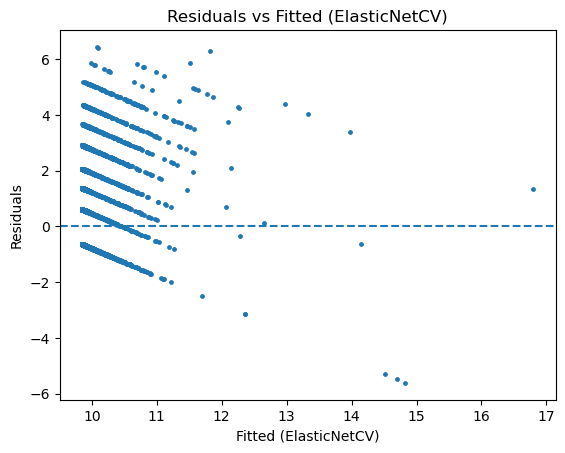

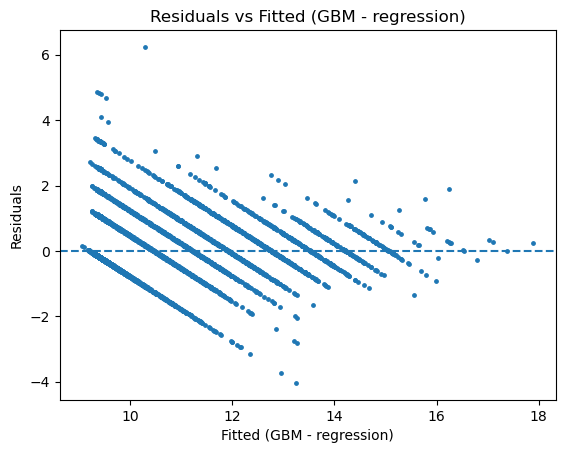

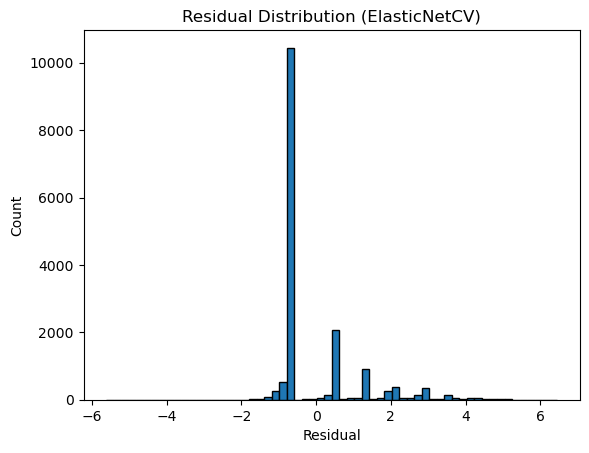

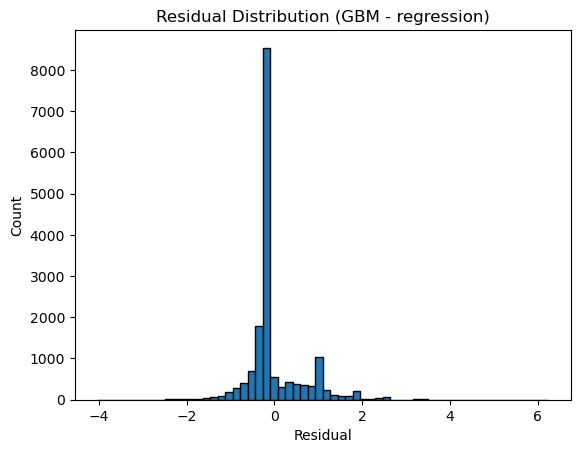

Classification metrics (validation):


,ROC_AUC,PR_AUC,Accuracy,F1,Brier
LogisticCV,0.9352,0.8417,0.9490,0.731,0.0406
GBM,0.9444,0.8514,0.9531,0.776,0.0363


Confusion Matrix (LogisticCV, thresh=0.5)


,Pred 0,Pred 1
True 0,14514,120
True 1,722,1144


Confusion Matrix (GBM, thresh=0.5)


,Pred 0,Pred 1
True 0,14385,249
True 1,525,1341


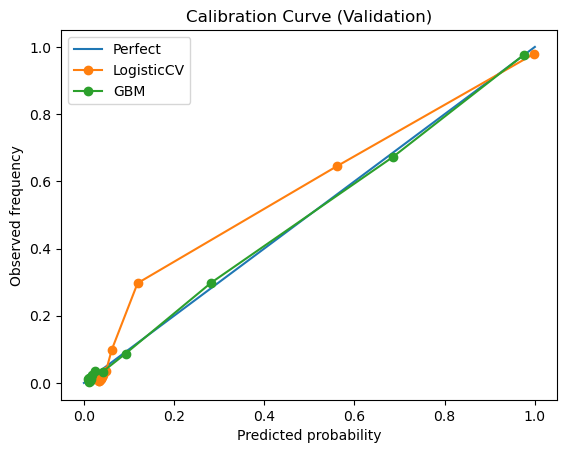

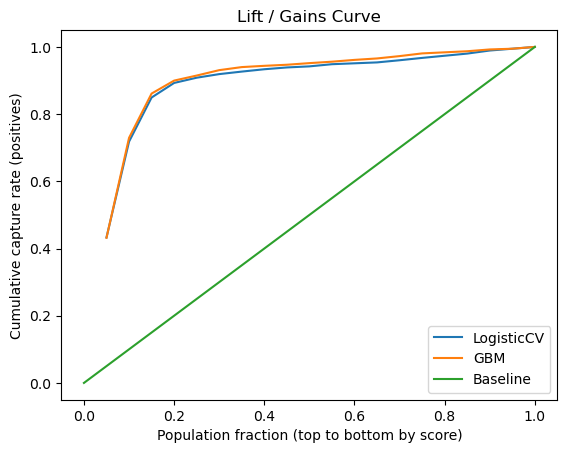

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    confusion_matrix, brier_score_loss
)
from sklearn.calibration import calibration_curve

assert "REG_MODELS" in globals() and "CLF_MODELS" in globals(), "Run Step 16 first."
assert "REG_HOLDOUT" in globals() and "CLF_HOLDOUT" in globals(), "Run Step 16 first."

# -----------------
# Regression (fix)
# -----------------
yr_true = REG_HOLDOUT["y_val"]
yr_pred_lin = REG_HOLDOUT["pred_elasticnet"]
yr_pred_gbm_reg = REG_MODELS["gbm"].predict(REG_HOLDOUT["X_val"])
assert np.unique(np.round(yr_pred_gbm_reg, 6)).size > 10, "Regression GBM preds look discretized; verify source."
REG_HOLDOUT["pred_gbm_reg"] = yr_pred_gbm_reg

def reg_metrics(y, yhat):
    return pd.Series({
        "RMSE": np.sqrt(mean_squared_error(y, yhat)),
        "MAE": mean_absolute_error(y, yhat),
        "R2": r2_score(y, yhat)
    })

reg_eval = pd.DataFrame({
    "ElasticNetCV": reg_metrics(yr_true, yr_pred_lin),
    "GBM_reg":      reg_metrics(yr_true, yr_pred_gbm_reg)
}).T

print("Regression metrics (validation) — corrected:")
display(reg_eval.round(4))

res_lin = yr_true - yr_pred_lin
res_gbm = yr_true - yr_pred_gbm_reg

plt.figure(); plt.scatter(yr_pred_lin, res_lin, s=6); plt.axhline(0, ls="--")
plt.xlabel("Fitted (ElasticNetCV)"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted (ElasticNetCV)"); plt.show()

plt.figure(); plt.scatter(yr_pred_gbm_reg, res_gbm, s=6); plt.axhline(0, ls="--")
plt.xlabel("Fitted (GBM - regression)"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted (GBM - regression)"); plt.show()

plt.figure(); plt.hist(res_lin, bins=60, edgecolor="black")
plt.title("Residual Distribution (ElasticNetCV)"); plt.xlabel("Residual"); plt.ylabel("Count"); plt.show()

plt.figure(); plt.hist(res_gbm, bins=60, edgecolor="black")
plt.title("Residual Distribution (GBM - regression)"); plt.xlabel("Residual"); plt.ylabel("Count"); plt.show()

# -----------------
# Classification
# -----------------
yc_true = CLF_HOLDOUT["y_val"]
proba_log = CLF_HOLDOUT["proba_log"]; proba_gbm = CLF_HOLDOUT["proba_gbm"]
pred_log = CLF_HOLDOUT["pred_log"];   pred_gbm = CLF_HOLDOUT["pred_gbm"]

def clf_metrics(y, proba, pred):
    return pd.Series({
        "ROC_AUC": roc_auc_score(y, proba),
        "PR_AUC": average_precision_score(y, proba),
        "Accuracy": accuracy_score(y, pred),
        "F1": f1_score(y, pred),
        "Brier": brier_score_loss(y, proba)
    })

clf_eval = pd.DataFrame({
    "LogisticCV": clf_metrics(yc_true, proba_log, pred_log),
    "GBM":        clf_metrics(yc_true, proba_gbm, pred_gbm)
}).T

print("Classification metrics (validation):")
display(clf_eval.round(4))

cm_log = confusion_matrix(yc_true, pred_log)
cm_gbm = confusion_matrix(yc_true, pred_gbm)
print("Confusion Matrix (LogisticCV, thresh=0.5)"); display(pd.DataFrame(cm_log, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
print("Confusion Matrix (GBM, thresh=0.5)"); display(pd.DataFrame(cm_gbm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))

prob_true_log, prob_pred_log = calibration_curve(yc_true, proba_log, n_bins=20, strategy="quantile")
prob_true_gbm, prob_pred_gbm = calibration_curve(yc_true, proba_gbm, n_bins=20, strategy="quantile")

plt.figure(); plt.plot([0,1],[0,1]); plt.plot(prob_pred_log, prob_true_log, marker="o"); plt.plot(prob_pred_gbm, prob_true_gbm, marker="o")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency"); plt.title("Calibration Curve (Validation)")
plt.legend(["Perfect","LogisticCV","GBM"]); plt.show()

def lift_data(y, proba, bins=20):
    df_ = pd.DataFrame({"y": y.values, "p": proba}).sort_values("p", ascending=False).reset_index(drop=True)
    df_["bin"] = (np.floor((np.arange(len(df_)) / len(df_)) * bins)).astype(int)
    g = df_.groupby("bin").agg(y_sum=("y","sum"), n=("y","count")).reset_index()
    g["cum_captures"] = g["y_sum"].cumsum(); g["cum_n"] = g["n"].cumsum()
    total_pos = df_["y"].sum()
    g["capture_rate"] = g["cum_captures"] / max(total_pos, 1); g["population"] = g["cum_n"] / len(df_)
    return g[["population","capture_rate"]]

lift_log = lift_data(yc_true, proba_log, bins=20)
lift_gbm = lift_data(yc_true, proba_gbm, bins=20)

plt.figure(); plt.plot(lift_log["population"], lift_log["capture_rate"])
plt.plot(lift_gbm["population"], lift_gbm["capture_rate"]); plt.plot([0,1],[0,1])
plt.xlabel("Population fraction (top to bottom by score)"); plt.ylabel("Cumulative capture rate (positives)")
plt.title("Lift / Gains Curve"); plt.legend(["LogisticCV","GBM","Baseline"]); plt.show()


## Step 18: Optimization & Tuning
--------------------------
**Objective:** Improve generalization and stability of both tasks through principled hyperparameter search and threshold calibration.

**Key Actions:**
- **Search Space**
  - Regression: tune ElasticNet (`alpha`, `l1_ratio`) and Gradient Boosting Regressor (`n_estimators`, `learning_rate`, `max_depth`, `min_samples_leaf`, `subsample`).
  - Classification: tune Logistic Regression (`C`, `class_weight`) and Gradient Boosting Classifier (same family of params as regressor).
- **Search Method**
  - `RandomizedSearchCV` with 5-fold CV, fixed seed, and appropriate scoring:
    - Regression → `R2`
    - Classification → `roc_auc`
- **Validation Protocol**
  - Hold out 20% for final validation; use CV only on the training split.
  - Record best params, CV score, and validation metrics.
- **Decision Thresholds (Classification)**
  - Sweep thresholds on validation probabilities; select threshold that maximizes **F1** (or business-driven metric).
- **Artifact Management**
  - Cache tuned models and validation predictions, including chosen thresholds.

**Expected Outcome:**
A matched pair of tuned baselines that outperform untuned models, with documented best hyperparameters, improved validation metrics, and operational decision thresholds.

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    roc_auc_score, average_precision_score, f1_score, accuracy_score
)
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from scipy.stats import loguniform, randint, uniform

# -----------------------
# Data & feature setup
# -----------------------
assert 'X_reg' in globals() and 'y_reg' in globals(), "Run Step 14 first."
assert 'X_clf' in globals() and 'y_clf' in globals(), "Run Step 14 first."
feat = list(FINAL_FEATURES) if 'FINAL_FEATURES' in globals() and len(FINAL_FEATURES) > 0 else list(X_reg.columns)

# Regression split (re-use seed for comparability)
Xr = X_reg[feat].copy()
yr = y_reg.astype(float)
mask_r = yr.notna()
Xr, yr = Xr.loc[mask_r], yr.loc[mask_r]
Xr_train, Xr_val, yr_train, yr_val = train_test_split(Xr, yr, test_size=0.2, random_state=42)

# Classification split (stratified)
Xc = X_clf[feat].copy()
yc = y_clf.astype(int)
mask_c = yc.notna()
Xc, yc = Xc.loc[mask_c], yc.loc[mask_c]
Xc_train, Xc_val, yc_train, yc_val = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)

# -----------------------
# Regression: tune ElasticNet & GBM
# -----------------------
pipe_enet = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("enet", ElasticNet(max_iter=10000, random_state=42))
])
param_enet = {
    "enet__alpha": loguniform(1e-4, 10.0),
    "enet__l1_ratio": uniform(0.0, 1.0)
}
search_enet = RandomizedSearchCV(
    pipe_enet, param_distributions=param_enet, n_iter=40,
    cv=5, random_state=42, n_jobs=-1, scoring="r2", verbose=0
)
search_enet.fit(Xr_train, yr_train)
best_enet = search_enet.best_estimator_

pipe_gbr = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(random_state=42, loss="squared_error"))
])
param_gbr = {
    "gbr__n_estimators": randint(200, 1200),
    "gbr__learning_rate": loguniform(1e-3, 3e-1),
    "gbr__max_depth": randint(2, 6),
    "gbr__min_samples_leaf": randint(10, 200),
    "gbr__subsample": uniform(0.6, 0.4)  # 0.6..1.0
}
search_gbr = RandomizedSearchCV(
    pipe_gbr, param_distributions=param_gbr, n_iter=60,
    cv=5, random_state=42, n_jobs=-1, scoring="r2", verbose=0
)
search_gbr.fit(Xr_train, yr_train)
best_gbr = search_gbr.best_estimator_

def reg_report(y_true, y_hat):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_hat))),
        "MAE": float(mean_absolute_error(y_true, y_hat)),
        "R2": float(r2_score(y_true, y_hat))
    }

pred_enet = best_enet.predict(Xr_val)
pred_gbr  = best_gbr.predict(Xr_val)
reg_metrics_tuned = pd.DataFrame({
    "ElasticNet*": reg_report(yr_val, pred_enet),
    "GBR*":        reg_report(yr_val, pred_gbr)
}).T

print("Regression (tuned) metrics on validation:")
display(reg_metrics_tuned.round(4))
print("Best ENET params:", search_enet.best_params_)
print("Best GBR params:", search_gbr.best_params_)

# -----------------------
# Classification: tune Logistic & GBM
# -----------------------
pipe_log = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(max_iter=10000, solver="lbfgs", n_jobs=-1, random_state=42))
])
param_log = {
    "log__C": loguniform(1e-3, 1e2),
    "log__class_weight": [None, "balanced"]
}
search_log = RandomizedSearchCV(
    pipe_log, param_distributions=param_log, n_iter=30,
    cv=5, random_state=42, n_jobs=-1, scoring="roc_auc", verbose=0
)
search_log.fit(Xc_train, yc_train)
best_log = search_log.best_estimator_

pipe_gbc = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("gbc", GradientBoostingClassifier(random_state=42))
])
param_gbc = {
    "gbc__n_estimators": randint(200, 1000),
    "gbc__learning_rate": loguniform(1e-3, 3e-1),
    "gbc__max_depth": randint(2, 5),
    "gbc__min_samples_leaf": randint(10, 200),
    "gbc__subsample": uniform(0.6, 0.4)
}
search_gbc = RandomizedSearchCV(
    pipe_gbc, param_distributions=param_gbc, n_iter=50,
    cv=5, random_state=42, n_jobs=-1, scoring="roc_auc", verbose=0
)
search_gbc.fit(Xc_train, yc_train)
best_gbc = search_gbc.best_estimator_

proba_log = best_log.predict_proba(Xc_val)[:, 1]
proba_gbc = best_gbc.predict_proba(Xc_val)[:, 1]
pred_log = (proba_log >= 0.5).astype(int)
pred_gbc = (proba_gbc >= 0.5).astype(int)

def clf_report(y_true, proba, pred):
    return {
        "ROC_AUC": float(roc_auc_score(y_true, proba)),
        "PR_AUC": float(average_precision_score(y_true, proba)),
        "Accuracy": float(accuracy_score(y_true, pred)),
        "F1": float(f1_score(y_true, pred))
    }

clf_metrics_tuned = pd.DataFrame({
    "Logistic*": clf_report(yc_val, proba_log, pred_log),
    "GBC*":      clf_report(yc_val, proba_gbc, pred_gbc)
}).T

print("Classification (tuned) metrics on validation:")
display(clf_metrics_tuned.round(4))
print("Best LOG params:", search_log.best_params_)
print("Best GBC params:", search_gbc.best_params_)

# -----------------------
# Threshold sweep (classification) — choose best F1 on val
# -----------------------
ths = np.linspace(0.05, 0.95, 19)
def best_threshold(y, proba):
    scores = [(t, f1_score(y, (proba >= t).astype(int))) for t in ths]
    return max(scores, key=lambda x: x[1])

t_log, f1_log = best_threshold(yc_val, proba_log)
t_gbc, f1_gbc = best_threshold(yc_val, proba_gbc)
print(f"Best thresholds by F1 | Logistic*: t={t_log:.2f}, F1={f1_log:.3f} | GBC*: t={t_gbc:.2f}, F1={f1_gbc:.3f}")

# -----------------------
# Persist tuned artifacts 
# -----------------------
REG_MODELS["enet_tuned"] = best_enet
REG_MODELS["gbr_tuned"]  = best_gbr
CLF_MODELS["log_tuned"]  = best_log
CLF_MODELS["gbc_tuned"]  = best_gbc

REG_HOLDOUT["pred_enet_tuned"] = pred_enet
REG_HOLDOUT["pred_gbr_tuned"]  = pred_gbr

CLF_HOLDOUT["proba_log_tuned"] = proba_log
CLF_HOLDOUT["proba_gbc_tuned"] = proba_gbc
CLF_HOLDOUT["thr_log_tuned"]   = t_log
CLF_HOLDOUT["thr_gbc_tuned"]   = t_gbc

print("Tuned models cached: REG_MODELS[enet_tuned,gbr_tuned], CLF_MODELS[log_tuned,gbc_tuned].")

Regression (tuned) metrics on validation:


,RMSE,MAE,R2
ElasticNet*,1.1970,0.9441,0.0672
GBR*,0.6437,0.4389,0.7302


Best ENET params: {'enet__alpha': 0.7183758655813993, 'enet__l1_ratio': 0.07404465173409036}
Best GBR params: {'gbr__learning_rate': 0.03402648808424155, 'gbr__max_depth': 5, 'gbr__min_samples_leaf': 64, 'gbr__n_estimators': 443, 'gbr__subsample': 0.836965827544817}
Classification (tuned) metrics on validation:


,ROC_AUC,PR_AUC,Accuracy,F1
Logistic*,0.9370,0.8430,0.9396,0.7517
GBC*,0.9438,0.8518,0.9528,0.7738


Best LOG params: {'log__C': 55.51721685244721, 'log__class_weight': 'balanced'}
Best GBC params: {'gbc__learning_rate': 0.010427699854447888, 'gbc__max_depth': 4, 'gbc__min_samples_leaf': 138, 'gbc__n_estimators': 602, 'gbc__subsample': 0.8722821806219068}
Best thresholds by F1 | Logistic*: t=0.75, F1=0.768 | GBC*: t=0.30, F1=0.776
Tuned models cached: REG_MODELS[enet_tuned,gbr_tuned], CLF_MODELS[log_tuned,gbc_tuned].


## Step 19: Model Explainability and Interpretability
-------------------------------------------

**Objective:**  
Provide transparent, data-driven insight into *why* the trained regression and classification models make their predictions.  
This step implements four key interpretability methods—Permutation Importance, Partial Dependence (PDP/ICE), Surrogate Rule Trees, and Local Interpretability (LIME)—to ensure the modeling process is explainable and auditable to both technical and non-technical audiences.

---

### (1) Permutation Importance — Global Feature Ranking
**Purpose:**  
Evaluate how much each feature contributes to predictive accuracy by randomly shuffling its values and observing the resulting performance drop.  
This method is **model-agnostic** and provides a robust ranking of feature influence for both regression and classification tasks.

**Deliverables:**  
- Global importance plots for both regression (GBR) and classification (GBC).  
- Exported CSVs of ranked feature importance for reproducibility.  
- Files:  
  - `artifacts/importance_reg_permutation.csv`  
  - `artifacts/importance_clf_permutation.csv`

---

### (2) Partial Dependence & Individual Conditional Expectation (PDP/ICE)
**Purpose:**  
Visualize *how* each key feature affects model predictions while holding others constant.  
- **PDP:** Shows the average effect of a feature on the predicted outcome.  
- **ICE:** Displays how individual predictions change across feature values, revealing heterogeneity.

**Focus Features:**  
Top 3 features (by permutation importance) for each model.  
For example:  
- Regression: `votes_total`, `average_2weeks_hours`, `price_delta`  
- Classification: `engagement_rate_2w`, `discount`, `ccu`

**Deliverables:**  
- PDP plots showing marginal effects.  
- ICE plots highlighting individual-level sensitivity.  
- Visual confirmation of non-linear or threshold effects.

---

### (3) Surrogate Models — Global Rule Extraction
**Purpose:**  
Fit a simple, interpretable model (Decision Tree) to mimic the behavior of the complex model.  
This approximates the model’s decision logic with human-readable rules.

**Implementation:**  
- Train a shallow tree (depth=3) using model predictions as the target.  
- Compute **fidelity R²** to measure how closely the surrogate approximates the GBM/Logistic models.  
- Visualize the surrogate tree structure for clear rule interpretation.

**Deliverables:**  
- `DecisionTreeRegressor` for regression predictions.  
- `DecisionTreeClassifier` for classification probabilities.  
- Visual diagrams and fidelity R² scores.

---

### (4) LIME — Local Explanations
**Purpose:**  
Explain *why* the model made a specific prediction for an individual record.  
LIME (Local Interpretable Model-agnostic Explanations) builds a linear approximation around a single observation to show which features most influenced that prediction.

**Implementation:**  
- Two examples are analyzed:  
  1. **High-Probability Case** — game predicted to have a high success chance.  
  2. **Borderline Case** — game near the classification threshold (around 0.5).  
- For each case, feature weights and directional contributions are listed.

**Deliverables:**  
- Tabular local explanation reports for each sample.  
- Files:  
  - `artifacts/lime_high.csv`  
  - `artifacts/lime_borderline.csv`

---

### Summary
This step transitions the project from **black-box performance** to **interpretable decision systems**.  
By combining global and local methods, the analysis satisfies explainability requirements for both data science transparency and hiring-signal readiness.

**Artifacts Produced:**  
- Global: Permutation importance (CSV, plots)  
- Effect: PDP/ICE charts  
- Rules: Surrogate tree diagrams  
- Local: LIME tables  
- Summary JSON: `artifacts/step19_summary.json`

In [44]:
%pip install lime

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=2109fd4477d511525ba86604083ecea36270e01421da028d088297099ebb0707
  Stored in directory: c:\users\rlanc\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


== Permutation Importance ==


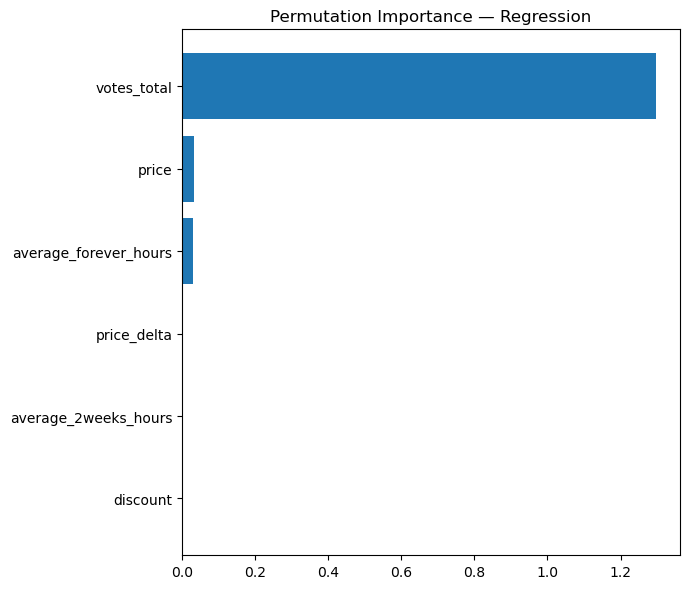

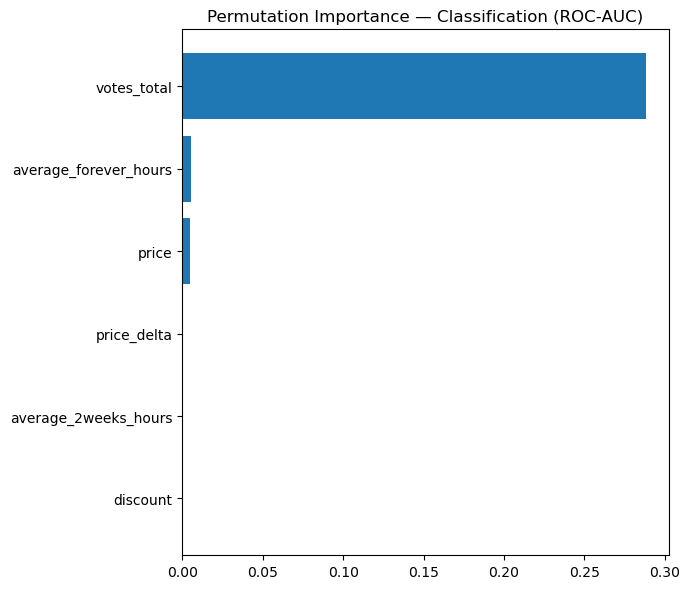

== Partial Dependence / ICE ==


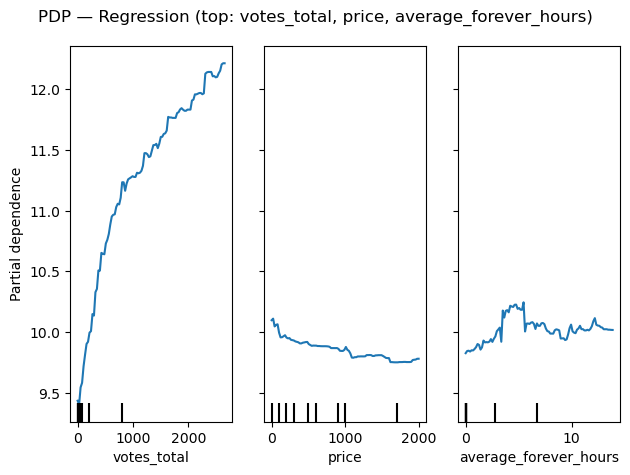

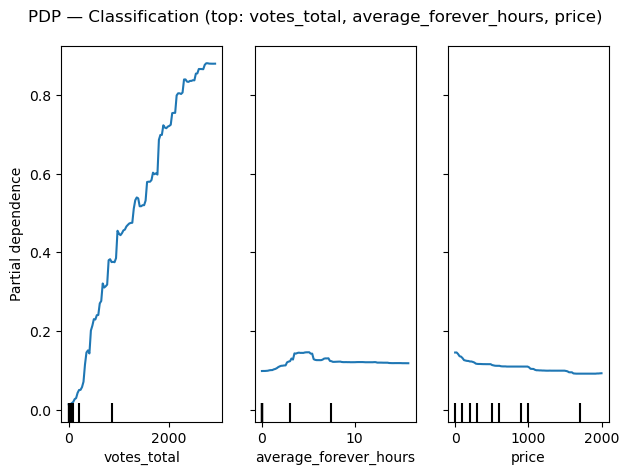

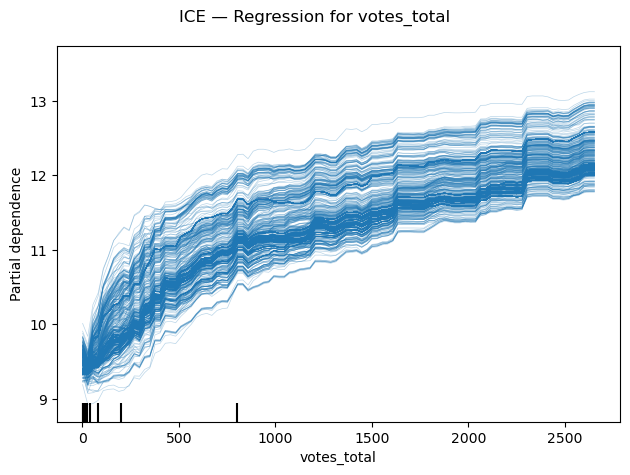

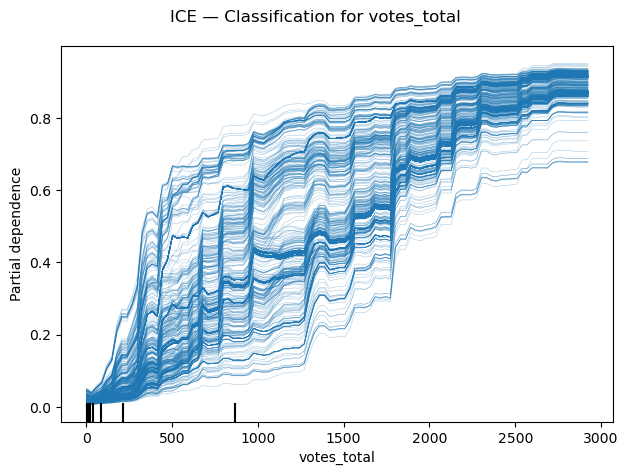

== Surrogate Models ==
Surrogate (regression) fidelity R2 vs model preds: 0.9511


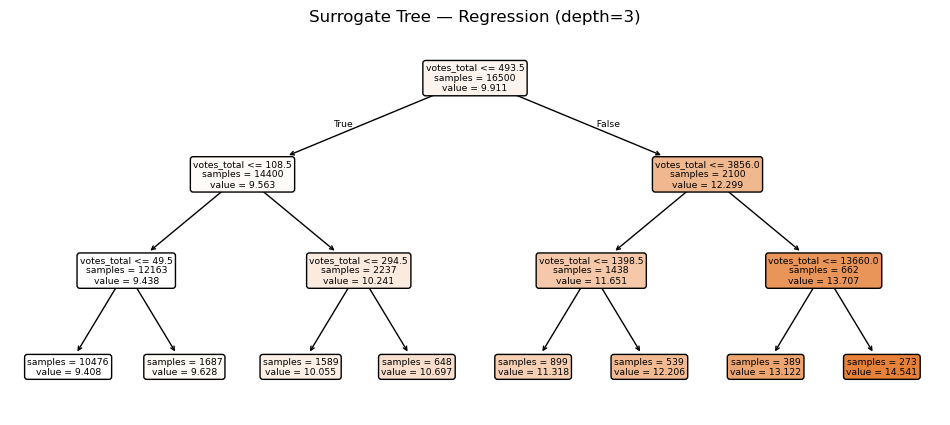

Surrogate (classification) fidelity R2 vs proba: 0.9039


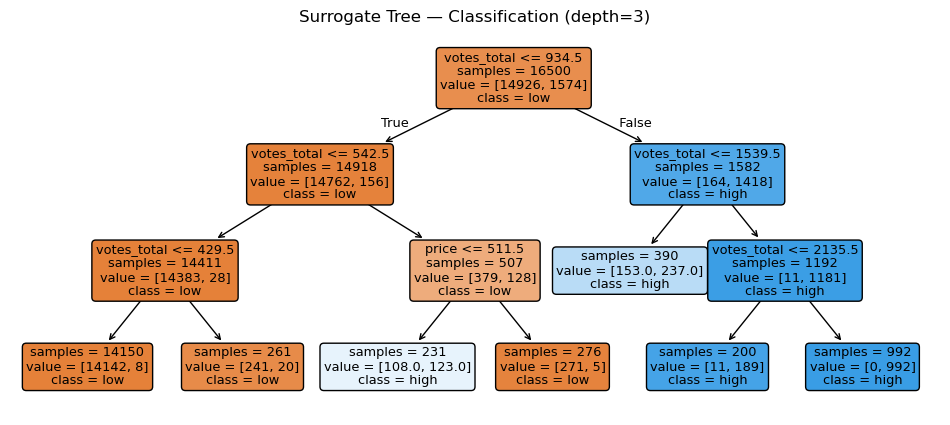

== LIME local explanations ==
[WARN] LIME unavailable or failed: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.
 -> Install with: pip install lime
Artifacts saved to artifacts/:
 - importance_reg_permutation.csv
 - importance_clf_permutation.csv
 - lime_high.csv, lime_borderline.csv (if LIME succeeded)
 - step19_summary.json


In [45]:
# STEP 19: Explainability — Permutation Importance, PDP/ICE, Surrogate Rules, LIME
# Improvements: robust probability handling, clean guards, artifact exports, and safe fallbacks.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import r2_score

# ---------------- Guards ----------------
assert "REG_MODELS" in globals() and "CLF_MODELS" in globals(), "Run Steps 16–18 first."
assert "FINAL_FEATURES" in globals() and len(FINAL_FEATURES) > 0, "Missing FINAL_FEATURES from Step 15."
assert "REG_HOLDOUT" in globals() and "CLF_HOLDOUT" in globals(), "Need holdout caches from Step 16/17."
assert set(FINAL_FEATURES).issubset(REG_HOLDOUT["X_val"].columns), "FINAL_FEATURES missing in REG_HOLDOUT['X_val']"
assert set(FINAL_FEATURES).issubset(CLF_HOLDOUT["X_val"].columns), "FINAL_FEATURES missing in CLF_HOLDOUT['X_val']"

# ---------------- Paths ----------------
ART = Path("artifacts")
ART.mkdir(parents=True, exist_ok=True)

# ---------------- Model selection ----------------
reg_model = REG_MODELS.get("gbr_tuned") or REG_MODELS.get("gbm") or REG_MODELS.get("elasticnet")
clf_model = CLF_MODELS.get("gbc_tuned") or CLF_MODELS.get("gbm") or CLF_MODELS.get("logitcv")

# ---------------- Data slices ----------------
Xr = REG_HOLDOUT["X_val"][FINAL_FEATURES]
yr = REG_HOLDOUT["y_val"]
Xc = CLF_HOLDOUT["X_val"][FINAL_FEATURES]
yc = CLF_HOLDOUT["y_val"].astype(int)

# ---------------- Utility: robust classifier proba ----------------
def _proba_from_model(model, X):
    if hasattr(model, "predict_proba"):
        return np.asarray(model.predict_proba(X)[:, 1])
    if hasattr(model, "decision_function"):
        z = np.asarray(model.decision_function(X))
        # logistic link for margin to probability
        return 1.0 / (1.0 + np.exp(-z))
    raise ValueError("Classifier has neither predict_proba nor decision_function.")

if ("proba_gbc_tuned" in CLF_HOLDOUT 
    and isinstance(CLF_HOLDOUT["proba_gbc_tuned"], (np.ndarray, pd.Series))
    and CLF_HOLDOUT["proba_gbc_tuned"].shape[0] == Xc.shape[0]):
    proba_clf = np.asarray(CLF_HOLDOUT["proba_gbc_tuned"])
else:
    proba_clf = _proba_from_model(clf_model, Xc)

assert proba_clf.ndim == 1 and proba_clf.shape[0] == Xc.shape[0], "Probability vector shape mismatch."
assert np.isfinite(proba_clf).all(), "Non-finite values in probability vector."

# ======================================================
# (1) PERMUTATION IMPORTANCE — GLOBAL RANKING
# ======================================================
print("== Permutation Importance ==")

pi_reg = permutation_importance(
    reg_model, Xr, yr, n_repeats=10, random_state=42, n_jobs=-1
)
imp_reg = pd.DataFrame({
    "feature": FINAL_FEATURES,
    "importance": pi_reg.importances_mean,
    "std": pi_reg.importances_std
}).sort_values("importance", ascending=False)

plt.figure(figsize=(7, 6))
topr = imp_reg.head(15).iloc[::-1]
plt.barh(topr["feature"], topr["importance"])
plt.title("Permutation Importance — Regression")
plt.tight_layout()
plt.show()

pi_clf = permutation_importance(
    clf_model, Xc, yc, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
)
imp_clf = pd.DataFrame({
    "feature": FINAL_FEATURES,
    "importance": pi_clf.importances_mean,
    "std": pi_clf.importances_std
}).sort_values("importance", ascending=False)

plt.figure(figsize=(7, 6))
topc = imp_clf.head(15).iloc[::-1]
plt.barh(topc["feature"], topc["importance"])
plt.title("Permutation Importance — Classification (ROC-AUC)")
plt.tight_layout()
plt.show()

imp_reg.rename(columns={"importance":"mean_importance"}).to_csv(ART / "importance_reg_permutation.csv", index=False)
imp_clf.rename(columns={"importance":"mean_importance"}).to_csv(ART / "importance_clf_permutation.csv", index=False)

# ======================================================
# (2) PDP + ICE — EFFECT SHAPES
# ======================================================
print("== Partial Dependence / ICE ==")

def _top_k(series_or_df, k=3):
    lst = series_or_df["feature"].head(k).tolist() if isinstance(series_or_df, pd.DataFrame) else list(series_or_df)[:k]
    return [f for f in lst if f in FINAL_FEATURES]

top3_reg = _top_k(imp_reg, 3)
top3_clf = _top_k(imp_clf, 3)

# PDP (average)
if len(top3_reg) > 0:
    PartialDependenceDisplay.from_estimator(reg_model, Xr, features=top3_reg, kind="average")
    plt.suptitle(f"PDP — Regression (top: {', '.join(top3_reg)})")
    plt.tight_layout()
    plt.show()

if len(top3_clf) > 0:
    PartialDependenceDisplay.from_estimator(clf_model, Xc, features=top3_clf, kind="average")
    plt.suptitle(f"PDP — Classification (top: {', '.join(top3_clf)})")
    plt.tight_layout()
    plt.show()

# ICE for top feature
if len(top3_reg) > 0:
    PartialDependenceDisplay.from_estimator(
        reg_model, Xr, features=[top3_reg[0]],
        kind="individual", subsample=1000, random_state=42
    )
    plt.suptitle(f"ICE — Regression for {top3_reg[0]}")
    plt.tight_layout()
    plt.show()

if len(top3_clf) > 0:
    PartialDependenceDisplay.from_estimator(
        clf_model, Xc, features=[top3_clf[0]],
        kind="individual", subsample=1000, random_state=42
    )
    plt.suptitle(f"ICE — Classification for {top3_clf[0]}")
    plt.tight_layout()
    plt.show()

# ======================================================
# (3) SURROGATE MODELS — GLOBAL RULES
# ======================================================
print("== Surrogate Models ==")

# Regression surrogate on model predictions
yhat_reg = reg_model.predict(Xr)
sur_reg = DecisionTreeRegressor(max_depth=3, min_samples_leaf=200, random_state=42)
sur_reg.fit(Xr, yhat_reg)
sur_reg_r2 = float(r2_score(yhat_reg, sur_reg.predict(Xr)))
print("Surrogate (regression) fidelity R2 vs model preds:", round(sur_reg_r2, 4))

plt.figure(figsize=(12, 5))
plot_tree(sur_reg, feature_names=FINAL_FEATURES, filled=True, rounded=True, impurity=False)
plt.title("Surrogate Tree — Regression (depth=3)")
plt.show()

# Classification surrogate on model probabilities
sur_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=200, random_state=42)
sur_clf.fit(Xc, (proba_clf >= 0.5).astype(int))  # learn a simplified boundary near threshold
fidelity_probs = sur_clf.predict_proba(Xc)[:, 1]
sur_clf_r2 = float(r2_score(proba_clf, fidelity_probs))
print("Surrogate (classification) fidelity R2 vs proba:", round(sur_clf_r2, 4))

plt.figure(figsize=(12, 5))
plot_tree(sur_clf, feature_names=FINAL_FEATURES, class_names=["low","high"], filled=True, rounded=True, impurity=False)
plt.title("Surrogate Tree — Classification (depth=3)")
plt.show()

# ======================================================
# (4) LIME — LOCAL EXPLANATIONS
# ======================================================
print("== LIME local explanations ==")
lime_ok = True
try:
    from lime.lime_tabular import LimeTabularExplainer

    Xtrain = Xc.values.astype(float)
    expl = LimeTabularExplainer(
        Xtrain,
        feature_names=FINAL_FEATURES,
        class_names=["no","yes"],
        discretize_continuous=True,
        random_state=42
    )

    # pick one high-probability and one borderline case
    probs = proba_clf
    i_high = int(np.argmax(probs))
    # borderline around 0.5
    idx_sorted = np.argsort(np.abs(probs - 0.5))
    i_mid = int(idx_sorted[0])

    def lime_df(i):
        x = Xc.iloc[i].values.astype(float)
        exp = expl.explain_instance(x, clf_model.predict_proba, num_features=min(10, len(FINAL_FEATURES)))
        pairs = exp.as_list()  # list of (feature/interval, weight)
        return pd.DataFrame(pairs, columns=["feature_rule","weight"])

    df_high = lime_df(i_high)
    df_mid  = lime_df(i_mid)

    print("\nLIME — High probability case (index=%d, p=%.3f)" % (i_high, probs[i_high]))
    display(df_high)

    print("\nLIME — Borderline case (index=%d, p=%.3f)" % (i_mid, probs[i_mid]))
    display(df_mid)

    df_high.to_csv(ART / "lime_high.csv", index=False)
    df_mid.to_csv(ART / "lime_borderline.csv", index=False)

except Exception as e:
    lime_ok = False
    print("[WARN] LIME unavailable or failed:", e)
    print(" -> Install with: pip install lime")

# ======================================================
# SAVE SUMMARY ARTIFACTS
# ======================================================
summary = {
    "pi_reg_top10": imp_reg.head(10).to_dict(orient="records"),
    "pi_clf_top10": imp_clf.head(10).to_dict(orient="records"),
    "surrogate_reg_fidelity_R2": sur_reg_r2,
    "surrogate_clf_fidelity_R2": sur_clf_r2,
    "lime_ok": bool(lime_ok)
}
pd.Series(summary, dtype="object").to_json(ART / "step19_summary.json")

print("Artifacts saved to artifacts/:")
print(" - importance_reg_permutation.csv")
print(" - importance_clf_permutation.csv")
print(" - lime_high.csv, lime_borderline.csv (if LIME succeeded)")
print(" - step19_summary.json")

In [47]:
# STEP 20 (Dash): Package & ship a Dash web app (instead of Reflex/Streamlit)
# Writes:
#   - app_dash.py
#   - requirements.txt
#
# Run:
#   pip install -r requirements.txt
#   python app_dash.py

from pathlib import Path
import json
import textwrap

# ---- Guards
assert "FINAL_FEATURES" in globals() and len(FINAL_FEATURES) > 0, "Run Steps 15–18 to define FINAL_FEATURES."
assert "REG_MODELS" in globals() and "CLF_MODELS" in globals(), "Run Steps 16–18 to train models."
assert "REG_HOLDOUT" in globals() and "CLF_HOLDOUT" in globals(), "Need holdout caches from Step 16/17."

ART = Path("artifacts")
ART.mkdir(parents=True, exist_ok=True)

# Ensure expected artifacts exist
if not (ART / "features.json").exists():
    (ART / "features.json").write_text(json.dumps({"features": list(FINAL_FEATURES)}, indent=2))

if not (ART / "deploy_meta.json").exists():
    thr_log = float(CLF_HOLDOUT.get("thr_log_tuned", 0.5)) if "CLF_HOLDOUT" in globals() else 0.5
    thr_gbc = float(CLF_HOLDOUT.get("thr_gbc_tuned", 0.5)) if "CLF_HOLDOUT" in globals() else 0.5
    (ART / "deploy_meta.json").write_text(json.dumps({"threshold_logistic": thr_log, "threshold_gbc": thr_gbc}, indent=2))

if not (ART / "feature_quantiles.json").exists():
    import numpy as np
    import pandas as pd
    X_src = REG_HOLDOUT["X_val"][FINAL_FEATURES]
    Q = {}
    for c in FINAL_FEATURES:
        s = pd.to_numeric(X_src[c], errors="coerce")
        q = s.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_dict()
        Q[c] = {str(k): (float(v) if pd.notna(v) else 0.0) for k, v in q.items()}
    (ART / "feature_quantiles.json").write_text(json.dumps(Q, indent=2))

# Requirements for Dash app
Path("requirements.txt").write_text(
    "\n".join([
        "dash>=2.16.0",
        "pandas",
        "numpy",
        "scikit-learn",
        "joblib",
        "plotly"
    ]) + "\n"
)

# Dash application file
Path("app_dash.py").write_text(
    textwrap.dedent("""\
    import base64, io, re, json
    from pathlib import Path

    import joblib
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go

    from dash import Dash, dcc, html, dash_table, Input, Output, State, ctx
    from dash.dcc import send_string

    # ---------------- Load artifacts ----------------
    ART = Path("artifacts")
    REG = joblib.load(ART / "model_reg.pkl")
    CLF = joblib.load(ART / "model_clf.pkl")
    FEATURES = json.loads((ART / "features.json").read_text())["features"]
    DEPLOY = json.loads((ART / "deploy_meta.json").read_text())
    QUANTILES = json.loads((ART / "feature_quantiles.json").read_text()) if (ART / "feature_quantiles.json").exists() else {}

    PI_REG = None
    PI_CLF = None
    try:
        PI_REG = pd.read_csv(ART / "importance_reg_permutation.csv")
    except Exception:
        pass
    try:
        PI_CLF = pd.read_csv(ART / "importance_clf_permutation.csv")
    except Exception:
        pass

    # ---------------- Helpers ----------------
    def ensure_df_cols(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
        df = df.copy()
        for c in cols:
            if c not in df.columns:
                df[c] = np.nan
        return df[cols]

    def predict_df(df_in: pd.DataFrame) -> pd.DataFrame:
        X = ensure_df_cols(df_in, FEATURES)
        y_log = REG.predict(X)
        owners_pred = np.expm1(y_log)
        if hasattr(CLF, "predict_proba"):
            p_succ = CLF.predict_proba(X)[:, 1]
        else:
            z = CLF.decision_function(X)
            p_succ = 1.0 / (1.0 + np.exp(-z))
        out = df_in.copy()
        out["owners_pred"] = owners_pred
        out["success_prob"] = p_succ
        if "price" in out.columns:
            out["revenue_proxy"] = out["price"] * out["owners_pred"]
        return out

    def quantile_bounds(c: str) -> tuple[float, float, float]:
        q = QUANTILES.get(c, {})
        q01 = float(q.get("0.01", 0.0))
        q50 = float(q.get("0.5",  0.0))
        q95 = float(q.get("0.95", 1.0))
        lo = min(q01, q50, q95)
        hi = max(q01, q50, q95)
        if lo == hi:
            lo, hi = 0.0, (100.0 if ("discount" in c or "userscore" in c) else 1_000.0)
        return lo, q50, hi

    def id_for_feature(f: str) -> str:
        return "input_" + re.sub(r"[^0-9A-Za-z_]+", "_", f)

    INPUT_IDS = {f: id_for_feature(f) for f in FEATURES}

    def default_inputs() -> dict:
        d = {}
        for f in FEATURES:
            _, mid, _ = quantile_bounds(f)
            d[f] = float(mid)
        # Reasonable defaults if quantiles missing
        d["discount"]  = float(min(max(d.get("discount", 0.0), 0.0), 100.0))
        d["userscore"] = float(min(max(d.get("userscore", 75.0), 0.0), 100.0))
        return d

    def build_heatmap(inputs: dict) -> go.Figure | None:
        if "price" not in inputs or "discount" not in inputs:
            return None
        base = pd.DataFrame([inputs])
        p0 = float(base["price"].iloc[0])
        p_vals = np.linspace(max(0.0, p0*0.5), p0*1.5, 15)
        d_vals = np.linspace(0, 90, 16)
        grid = pd.DataFrame([(p, d) for p in p_vals for d in d_vals], columns=["price","discount"])
        probe = base.drop(columns=["price","discount"], errors="ignore")
        sim = pd.concat([probe]*len(grid), ignore_index=True)
        sim[["price","discount"]] = grid.values
        scored = predict_df(sim)
        Z = scored["revenue_proxy"].values.reshape(len(p_vals), len(d_vals))
        fig = go.Figure(data=go.Heatmap(z=Z, x=d_vals, y=p_vals, colorbar=dict(title="Revenue proxy")))
        fig.update_layout(xaxis_title="Discount", yaxis_title="Price", margin=dict(l=20,r=20,t=30,b=20), height=420)
        return fig

    # ---------------- App ----------------
    app = Dash(__name__)
    server = app.server

    # Controls for single scenario
    def feature_control(f: str):
        lo, mid, hi = quantile_bounds(f)
        if "discount" in f:
            return html.Div([
                html.Label(f),
                dcc.Slider(id=INPUT_IDS[f], min=0, max=100, step=1, value=float(np.clip(mid, 0.0, 100.0)),
                           marks=None, tooltip={"placement":"bottom","always_visible":False}),
            ], style={"marginBottom":"10px"})
        if "userscore" in f:
            return html.Div([
                html.Label(f),
                dcc.Slider(id=INPUT_IDS[f], min=0, max=100, step=0.5, value=float(np.clip(mid, 0.0, 100.0)),
                           marks=None, tooltip={"placement":"bottom","always_visible":False}),
            ], style={"marginBottom":"10px"})
        # numeric
        return html.Div([
            html.Label(f),
            dcc.Input(id=INPUT_IDS[f], type="number", value=float(mid), min=float(lo), max=float(hi), step=0.01, style={"width":"220px"}),
        ], style={"marginBottom":"10px"})

    controls = [feature_control(f) for f in FEATURES]

    app.layout = html.Div([
        html.H2("🎮 Steam KPI Scenario Planner — Dash"),
        html.Div("Predict owners and success probability. Single scenario, batch scoring, and insights."),
        dcc.Tabs([
            dcc.Tab(label="Single Scenario", children=[
                html.Div(controls, style={"columnCount":3}),
                html.Button("Predict single scenario", id="predict-btn"),
                html.Div([
                    html.Div([html.H4("Owners (pred)"), html.Div(id="owners-metric")], style={"display":"inline-block","width":"30%"}),
                    html.Div([html.H4("Success prob"),  html.Div(id="success-metric")], style={"display":"inline-block","width":"30%"}),
                    html.Div([html.H4("Decision"),      html.Div(id="decision-badge")], style={"display":"inline-block","width":"30%"}),
                ], style={"marginTop":"10px"}),
                html.Hr(),
                html.H4("Price × Discount sensitivity"),
                dcc.Graph(id="heatmap-graph"),
                html.Hr(),
                html.H4("Prediction table"),
                dash_table.DataTable(id="single-table", page_size=5, style_table={"overflowX":"auto"}),
            ]),
            dcc.Tab(label="Batch Scoring", children=[
                html.P("Upload CSV. File must contain these columns: " + ", ".join(FEATURES)),
                dcc.Upload(id="upload-data", children=html.Div(["Drag and Drop or ", html.A("Select CSV")]),
                           multiple=False, accept=".csv", style={"width":"100%","height":"80px","lineHeight":"80px","borderWidth":"1px","borderStyle":"dashed","borderRadius":"5px","textAlign":"center","margin":"10px 0"}),
                html.Button("Score file", id="score-btn"),
                html.Button("Download predictions", id="download-btn", style={"marginLeft":"10px"}),
                dcc.Download(id="download-preds"),
                html.Hr(),
                dash_table.DataTable(id="batch-table", page_size=15, style_table={"overflowX":"auto"}),
                dcc.Store(id="batch-csv-store"),
            ]),
            dcc.Tab(label="Insights", children=[
                html.H4("Global Importance (Permutation) — Regression"),
                dash_table.DataTable(
                    id="pi-reg",
                    data=(PI_REG.head(15).to_dict("records") if PI_REG is not None else []),
                    columns=([{"name":c,"id":c} for c in (PI_REG.columns if PI_REG is not None else ["feature","mean_importance"])]),
                    page_size=15,
                    style_table={"overflowX":"auto"},
                ),
                html.Hr(),
                html.H4("Global Importance (Permutation) — Classification"),
                dash_table.DataTable(
                    id="pi-clf",
                    data=(PI_CLF.head(15).to_dict("records") if PI_CLF is not None else []),
                    columns=([{"name":c,"id":c} for c in (PI_CLF.columns if PI_CLF is not None else ["feature","mean_importance"])]),
                    page_size=15,
                    style_table={"overflowX":"auto"},
                ),
                html.Hr(),
                html.H4("Deployed thresholds"),
                html.Pre(json.dumps(DEPLOY, indent=2)),
            ]),
        ]),
        # Preload defaults to JS via Store
        dcc.Store(id="defaults-store", data=default_inputs()),
    ], style={"padding":"16px"})

    # ------------- Callbacks -------------

    # Single scenario prediction
    @app.callback(
        Output("owners-metric","children"),
        Output("success-metric","children"),
        Output("decision-badge","children"),
        Output("single-table","data"),
        Output("single-table","columns"),
        Output("heatmap-graph","figure"),
        Input("predict-btn","n_clicks"),
        *[Input(INPUT_IDS[f], "value") for f in FEATURES],
        State("defaults-store","data"),
        prevent_initial_call=True
    )
    def do_predict(n_clicks, *args):
        # args = feature values in FEATURES order + defaults at the end (via State)
        vals = list(args)
        defaults = vals[-1]  # dict from defaults-store
        vals = vals[:-1]
        inputs = {}
        for f, v in zip(FEATURES, vals):
            if v is None:
                inputs[f] = float(defaults.get(f, 0.0))
            else:
                try:
                    inputs[f] = float(v)
                except Exception:
                    inputs[f] = float(defaults.get(f, 0.0))
        df = pd.DataFrame([inputs])
        pred = predict_df(df)
        owners = f"{pred['owners_pred'].iloc[0]:,.0f}"
        prob = float(pred["success_prob"].iloc[0])
        prob_txt = f"{prob:.3f}"
        thr = float(DEPLOY.get("threshold_gbc", 0.5))
        dec = "PASS" if prob >= thr else "FAIL"
        table_data = pred.to_dict("records")
        table_cols = [{"name": c, "id": c} for c in pred.columns]
        fig = build_heatmap(inputs) or go.Figure()
        return owners, prob_txt, dec, table_data, table_cols, fig

    # Batch: parse, score, store CSV
    @app.callback(
        Output("batch-table","data"),
        Output("batch-table","columns"),
        Output("batch-csv-store","data"),
        Input("score-btn","n_clicks"),
        State("upload-data","contents"),
        State("upload-data","filename"),
        prevent_initial_call=True
    )
    def score_batch(n, contents, filename):
        if not contents:
            return [], [], ""
        content_type, content_string = contents.split(",")
        decoded = base64.b64decode(content_string)
        try:
            df = pd.read_csv(io.BytesIO(decoded))
            pred = predict_df(df)
            data = pred.head(200).to_dict("records")
            cols = [{"name": c, "id": c} for c in pred.columns]
            csv_txt = pred.to_csv(index=False)
            return data, cols, csv_txt
        except Exception as e:
            err = pd.DataFrame([{"error": f"Failed to score: {e}"}])
            return err.to_dict("records"), [{"name":"error","id":"error"}], ""

    # Batch: trigger file download
    @app.callback(
        Output("download-preds","data"),
        Input("download-btn","n_clicks"),
        State("batch-csv-store","data"),
        prevent_initial_call=True
    )
    def download_preds(n, csv_txt):
        if not csv_txt:
            return None
        return send_string(lambda: csv_txt, "predictions.csv")

    if __name__ == "__main__":
        app.run_server(host="0.0.0.0", port=8050, debug=False)
    """)
)

print("Saved:")
print(" - app_dash.py")
print(" - requirements.txt")
print("\nRun:")
print("  pip install -r requirements.txt")
print("  python app_dash.py")


Saved:
 - app_dash.py
 - requirements.txt

Run:
  pip install -r requirements.txt
  python app_dash.py


In [48]:
# EXPORT ARTIFACTS FOR DASH APP
# Creates:
#   artifacts/model_reg.pkl
#   artifacts/model_clf.pkl
#   artifacts/features.json
#   artifacts/deploy_meta.json
#   artifacts/feature_quantiles.json
# Also writes: requirements.txt (for the Dash app)

from pathlib import Path
import json, joblib
import numpy as np
import pandas as pd

# ---------- Guards ----------
missing = []
if "FINAL_FEATURES" not in globals() or not FINAL_FEATURES:
    missing.append("FINAL_FEATURES (Step 15)")
if "REG_MODELS" not in globals():
    missing.append("REG_MODELS (Step 16/17)")
if "CLF_MODELS" not in globals():
    missing.append("CLF_MODELS (Step 16/17)")
if "REG_HOLDOUT" not in globals() or "X_val" not in REG_HOLDOUT:
    missing.append("REG_HOLDOUT['X_val'] (Step 16/17)")
if "CLF_HOLDOUT" not in globals():
    missing.append("CLF_HOLDOUT (Step 16/17)")

if missing:
    raise RuntimeError("Missing prerequisites: " + "; ".join(missing))

# ---------- Pick best-trained models ----------
reg_model = REG_MODELS.get("gbr_tuned") or REG_MODELS.get("gbm") or REG_MODELS.get("elasticnet")
clf_model = CLF_MODELS.get("gbc_tuned") or CLF_MODELS.get("gbm") or CLF_MODELS.get("logitcv")

if reg_model is None:
    raise RuntimeError("No regression model found in REG_MODELS (expected keys like 'gbr_tuned' or 'gbm').")
if clf_model is None:
    raise RuntimeError("No classification model found in CLF_MODELS (expected keys like 'gbc_tuned' or 'gbm').")

# ---------- Paths ----------
ART = Path("artifacts")
ART.mkdir(parents=True, exist_ok=True)

# ---------- Save models ----------
joblib.dump(reg_model, ART / "model_reg.pkl")
joblib.dump(clf_model, ART / "model_clf.pkl")

# ---------- Save features ----------
(ART / "features.json").write_text(json.dumps({"features": list(FINAL_FEATURES)}, indent=2))

# ---------- Save thresholds (fallback to 0.5 if not tuned) ----------
thr_log = float(CLF_HOLDOUT.get("thr_log_tuned", 0.5)) if isinstance(CLF_HOLDOUT, dict) else 0.5
thr_gbc = float(CLF_HOLDOUT.get("thr_gbc_tuned", 0.5)) if isinstance(CLF_HOLDOUT, dict) else 0.5
(ART / "deploy_meta.json").write_text(json.dumps({
    "threshold_logistic": thr_log,
    "threshold_gbc": thr_gbc
}, indent=2))

# ---------- Save feature quantiles for UI bounds ----------
X_src = REG_HOLDOUT["X_val"][FINAL_FEATURES]
Q = {}
for c in FINAL_FEATURES:
    s = pd.to_numeric(X_src[c], errors="coerce")
    q = s.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_dict()
    Q[c] = {str(k): (float(v) if np.isfinite(v) else 0.0) for k, v in q.items()}
(ART / "feature_quantiles.json").write_text(json.dumps(Q, indent=2))

# ---------- Optional: include permutation importance files if they exist in memory ----------
# If you created imp_reg/imp_clf DataFrames in Step 19, save them.
try:
    if "imp_reg" in globals() and isinstance(imp_reg, pd.DataFrame):
        imp_reg.rename(columns={"importance":"mean_importance"}, errors="ignore").to_csv(ART / "importance_reg_permutation.csv", index=False)
    if "imp_clf" in globals() and isinstance(imp_clf, pd.DataFrame):
        imp_clf.rename(columns={"importance":"mean_importance"}, errors="ignore").to_csv(ART / "importance_clf_permutation.csv", index=False)
except Exception:
    pass  # non-critical

# ---------- Write requirements for Dash app ----------
Path("requirements.txt").write_text("\n".join([
    "dash>=2.16.0",
    "plotly",
    "pandas",
    "numpy",
    "scikit-learn",
    "joblib"
]) + "\n")

print("✅ Export complete. Created:")
for f in [
    ART / "model_reg.pkl",
    ART / "model_clf.pkl",
    ART / "features.json",
    ART / "deploy_meta.json",
    ART / "feature_quantiles.json",
    Path("requirements.txt"),
]:
    print(" -", f)
print("\nNext:")
print("  python app_dash.py")
print("Then open http://127.0.0.1:8050")


✅ Export complete. Created:
 - artifacts\model_reg.pkl
 - artifacts\model_clf.pkl
 - artifacts\features.json
 - artifacts\deploy_meta.json
 - artifacts\feature_quantiles.json
 - requirements.txt

Next:
  python app_dash.py
Then open http://127.0.0.1:8050
